In [1]:
#import necessary packages
import ee
from IPython.display import Image
import folium
import geehydro
import pandas as pd
from datetime import datetime
#import cartopy.crs as ccrs
#import cartopy.io.img_tiles as cimgt
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pprint
import geopandas
import datetime
import matplotlib.pyplot as plt
import re
from mpl_toolkits.basemap import Basemap
from IPython.display import Image
import urllib
import numpy as np
from pandas_geojson import to_geojson
from PIL import Image
import requests
from io import BytesIO
from matplotlib import cm
import os

In [2]:
# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

Enter verification code: 4/1AbUR2VM5Ko2oIKHCcJhpyMiIa1GfqeDMt1v17NdckwU_ShSjK5h6M5i60fM

Successfully saved authorization token.


In [3]:
#STEPS for SYSY creation 

#AOI = ee.Geometry.Point(11.50, 44.98)
#POLYGON = ee.Geometry.Polygon([[11.004490043487136, 44.44422303449173], [11.811985160674636,44.44422303449173], [11.811985160674636,45.20008726989075], [11.004490043487136,45.20008726989075], [11.004490043487136,44.44422303449173]])
#START_DATE = '2017-01-01'
#END_DATE = '2019-12-31' # 5 years
CLOUD_FILTER = 60
CLD_PRB_THRESH = 30
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 50

In [4]:
#Steps for S2cloudless
#create a S2_SR collection
S2collection = (ee.ImageCollection("COPERNICUS/S2_SR")
        .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', CLOUD_FILTER))
        #.filterBounds(POLYGON)
        #.filterDate(START_DATE, END_DATE)
        #.filter(ee.Filter.calendarRange(3,6,"month"))
        .select (['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'SCL' ])
        .sort("system:time_start"))


#create a S2_cloud_probability collection
S2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY'))
        #.filterBounds(POLYGON)
        #.filterDate(START_DATE, END_DATE)
        #.filter(ee.Filter.calendarRange(3,6,"month")))


#join the two collections above by system_index (acquisiiton date/time)
joined = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': S2collection,
        'secondary': S2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))
  
  

def add_cloud_bands(img):
    # Get s2cloudless image, subset the probability band.
    cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

    # Condition s2cloudless by the probability threshold value.
    is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

    # Add the cloud probability layer and cloud mask as image bands.
    return img.addBands(ee.Image([cld_prb, is_cloud]))



#define cloud shadow mask component 
def add_shadow_bands(img):
    # Identify water pixels from the SCL band.
    not_water = img.select('SCL').neq(6)

    # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
    SR_BAND_SCALE = 1e4
    dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

    # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
    shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')));

    # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
    cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
        .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
        .select('distance')
        .mask()
        .rename('cloud_transform'))

    # Identify the intersection of dark pixels with cloud shadow projection.
    shadows = cld_proj.multiply(dark_pixels).rename('shadows')

    # Add dark pixels, cloud projection, and identified shadows as image bands.
    return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))


#function to add cloud and cloud shadow mask
def add_cld_shdw_mask(img):
    # Add cloud component bands.
    img_cloud = add_cloud_bands(img)

    # Add cloud shadow component bands.
    img_cloud_shadow = add_shadow_bands(img_cloud)

    # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
    is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

    # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
    # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
    is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
        .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
        .rename('cloudmask'))

    # Add the final cloud-shadow mask to the image.
    return img_cloud_shadow.addBands(is_cld_shdw)

def apply_cld_shdw_mask(img):
    # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
    not_cld_shdw = img.select('cloudmask').Not()

    # Subset reflectance bands and update their masks, return the result.
    return img.select('B.*').updateMask(not_cld_shdw)

S2joined = joined.map(add_cld_shdw_mask)
S2joined_cloudfree = S2joined.map(apply_cld_shdw_mask)
#print(S2joined.toList(1).getInfo())


In [5]:
#read in data and parse through each point
data = pd.read_csv("../Desktop/SENSE_CDT/GIS/LUCAS_HARMO/HARMO_USED/GEE_import/PythonImport_BandF_BARE_away20m_V2copy.csv")

datecolumn = []
    
for i in data["H_survey_d"]:
    #print(i[19:26])
    dt_string = i 
    format = '%d/%m/%y'
    dt_object = datetime.datetime.strptime(dt_string, format)
    
    #print(dt_object)
    datecolumn.append(str(dt_object)[:-9])
    
#print(datecolumn)

data["newdate"] = datecolumn

data

field_1  POINT_ID H_survey_d       H_lc1_labe Remark Crop_resid  \
0          0  26841944   06/07/18         Potatoes      y          y   
1          1  27401840   26/08/18  Other bare soil      y          y   
2          3  28181874   08/07/18  Other bare soil      y          y   
3          5  28761726   26/06/18  Other bare soil      y          y   
4          6  28761906   08/08/18  Other bare soil      y          y   
..       ...       ...        ...              ...    ...        ...   
403      604  56502420   10/08/18     Common wheat      y          y   
404      605  56642566   06/12/18        Sunflower      y          y   
405      606  56722664   04/12/18        Sunflower      y          y   
406      607  56802486   27/08/18       Dry pulses      y          n   
407      609  57102668   16/11/18  Other bare soil      y          y   

    Crop_level Roughness      ID  H_point_id  ... 2015A_BI_3 2015A_BI_4  \
0            m         n   60809    26841944  ...      693.0      115.0   
1            h         n   72867    27401840  ...      553.0       98.0   
2            l         n  218396    28181874  ...      557.0       87.0   
3            h         n  437658    28761726  ...      522.0       91.0   
4            l         n   84683    28761906  ...      544.0       89.0   
..         ...       ...     ...         ...  ...        ...        ...   
403          l         n  334191    56502420  ...      597.0       74.0   
404          l         n  413907    56642566  ...      499.0       68.0   
405          m         n  425113    56722664  ...      486.0       70.0   
406        NaN         n  291638    56802486  ...      500.0       63.0   
407          l         n  311293    57102668  ...        NaN        NaN   

    2015A_BI_5 2015A_BI_6  2015A_BI_7  2015A_BI_8 2015A_BI_9  2015A_BI10  \
0          6.0      65.39       319.0        29.0       38.0       298.0   
1          2.0      64.90       251.0        22.0       28.0       237.0   
2          4.0      57.27       234.0        31.0       36.0       218.0   
3          2.0      67.19       247.0        22.0       26.0       220.0   
4          6.0      57.77       234.0        34.0       38.0       215.0   
..         ...        ...         ...         ...        ...         ...   
403       35.0      24.22       202.0       111.0      187.0       118.0   
404       24.0      32.78       180.0        78.0      171.0        79.0   
405       22.0      35.75       183.0        75.0      175.0        78.0   
406       27.0      24.40       164.0        89.0      157.0        90.0   
407        NaN        NaN         NaN         NaN        NaN         NaN   

      SOC     newdate  
0     4.3  2018-07-06  
1    13.8  2018-08-26  
2    12.1  2018-07-08  
3     3.0  2018-06-26  
4     7.9  2018-08-08  
..    ...         ...  
403  18.5  2018-08-10  
404  20.2  2018-12-06  
405  12.9  2018-12-04  
406  13.6  2018-08-27  
407  20.6  2018-11-16  

[408 rows x 136 columns]

In [6]:
data_subset = data[data["2015A_So_1"]== "CM"]
data_subsetbare = data_subset[data_subset["Crop_resid"]=="n"]
#to see the column names
#print(list(data_subsetbare))

data_subsetbarelow = data_subset[data_subset["Crop_resid"]=="y"][data_subset["Crop_level"]=="l"]
data_subsetbaremid = data_subset[data_subset["Crop_resid"]=="y"][data_subset["Crop_level"]=="m"]
data_subsetbarehi = data_subset[data_subset["Crop_resid"]=="y"][data_subset["Crop_level"]=="h"]
data_subsetbare

/var/folders/96/nqm4g9gx5fbfn4hd2ppmp12w0000gn/T/ipykernel_93148/1329627337.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_subsetbarelow = data_subset[data_subset["Crop_resid"]=="y"][data_subset["Crop_level"]=="l"]
/var/folders/96/nqm4g9gx5fbfn4hd2ppmp12w0000gn/T/ipykernel_93148/1329627337.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_subsetbaremid = data_subset[data_subset["Crop_resid"]=="y"][data_subset["Crop_level"]=="m"]
/var/folders/96/nqm4g9gx5fbfn4hd2ppmp12w0000gn/T/ipykernel_93148/1329627337.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_subsetbarehi = data_subset[data_subset["Crop_resid"]=="y"][data_subset["Crop_level"]=="h"]


field_1  POINT_ID H_survey_d                H_lc1_labe Remark Crop_resid  \
134      241  34322722   30/05/18                     Maize      y          n   
136      244  34422704   02/06/18                     Maize      y          n   
152      274  35202306   31/05/18                     Maize      y          n   
155      277  35522294   12/06/18                     Maize      y          n   
164      299  36382330   27/05/18           Other bare soil      y          n   
190      328  37602708   19/07/18           Other bare soil      y          n   
215      358  38622774   28/09/18           Other bare soil      y          n   
256      430  45003694   22/10/18           Other bare soil      y          n   
257      431  45023726   20/10/18                    Barley      y          n   
262      436  45482830   13/09/18                     Maize      y          n   
264      438  45663622   24/09/18              Common wheat      y          n   
265      439  45763604   11/09/18           Other bare soil      y          n   
266      440  45783000   15/08/18              Common wheat      y          n   
275      452  46662920   24/08/18           Other bare soil      y          n   
291      470  47441950   18/07/18  Mixed cereals for fodder      y          n   
381      579  53363818   15/09/18           Other bare soil      y          n   

    Crop_level Roughness      ID  H_point_id  ... 2015A_BI_3 2015A_BI_4  \
134        NaN         n   88703    34322722  ...      767.0       88.0   
136        NaN         n   88702    34422704  ...      767.0       87.0   
152        NaN         n  258541    35202306  ...     1326.0      132.0   
155        NaN         n  319933    35522294  ...     1122.0      118.0   
164        NaN         n  255055    36382330  ...      686.0       76.0   
190        NaN         n  322790    37602708  ...      736.0       74.0   
215        NaN         n  385376    38622774  ...      725.0       66.0   
256        NaN         n  248517    45003694  ...      718.0       77.0   
257        NaN         n  247327    45023726  ...      764.0       82.0   
262        NaN         n  288808    45482830  ...      849.0      109.0   
264        NaN         n  320120    45663622  ...      717.0       73.0   
265        NaN         n  351258    45763604  ...      646.0       70.0   
266        NaN         n  338518    45783000  ...      678.0       91.0   
275        NaN         n  378855    46662920  ...      603.0       84.0   
291        NaN         n  263836    47441950  ...     1033.0      157.0   
381        NaN         n  351251    53363818  ...      682.0       77.0   

    2015A_BI_5 2015A_BI_6  2015A_BI_7  2015A_BI_8 2015A_BI_9  2015A_BI10  \
134       39.0      28.07       258.0       121.0      121.0       245.0   
136       38.0      28.13       257.0       120.0      120.0       243.0   
152       80.0      15.73       376.0       257.0      265.0       352.0   
155       69.0      14.73       325.0       223.0      239.0       284.0   
164       43.0      14.36       204.0       147.0      153.0       167.0   
190       53.0       9.75       198.0       169.0      173.0       186.0   
215       49.0       9.33       196.0       158.0      183.0       184.0   
256       37.0      23.07       224.0       128.0      212.0       159.0   
257       42.0      23.37       239.0       138.0      223.0       173.0   
262       52.0      26.74       299.0       163.0      299.0       174.0   
264       43.0      19.73       219.0       139.0      182.0       177.0   
265       37.0      22.31       207.0       124.0      156.0       159.0   
266       39.0      30.49       247.0       127.0      247.0       132.0   
275       30.0      36.58       232.0       101.0      232.0       102.0   
291       26.0      51.26       420.0        93.0       93.0       369.0   
381       33.0      26.29       225.0       115.0      225.0       133.0   

      SOC     newdate  
134  12.6  2018-05-30  
136  16.1 

/var/folders/96/nqm4g9gx5fbfn4hd2ppmp12w0000gn/T/ipykernel_20106/2184229722.py:261: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure() #figsize=(10,30))


<Figure size 432x288 with 0 Axes>

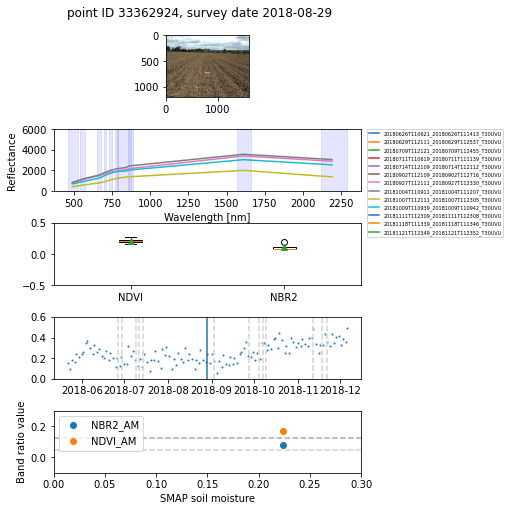

<Figure size 432x288 with 0 Axes>

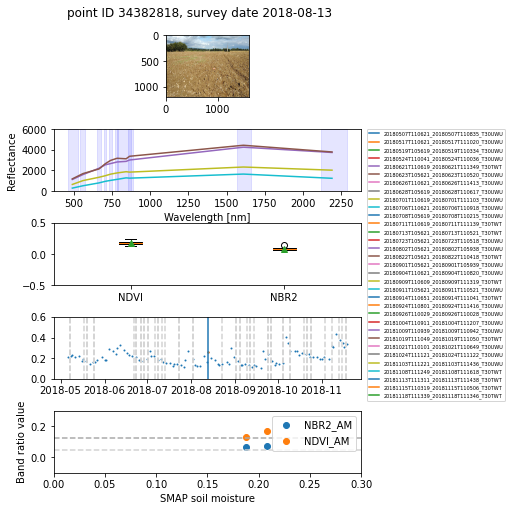

<Figure size 432x288 with 0 Axes>

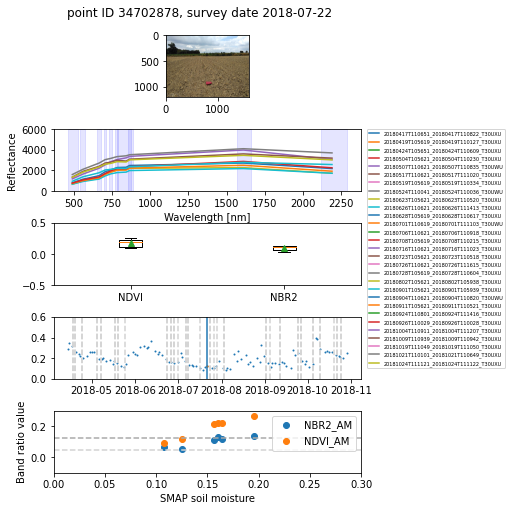

<Figure size 432x288 with 0 Axes>

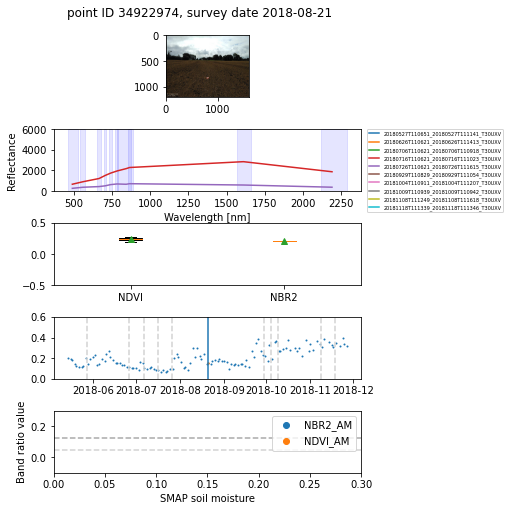

<Figure size 432x288 with 0 Axes>

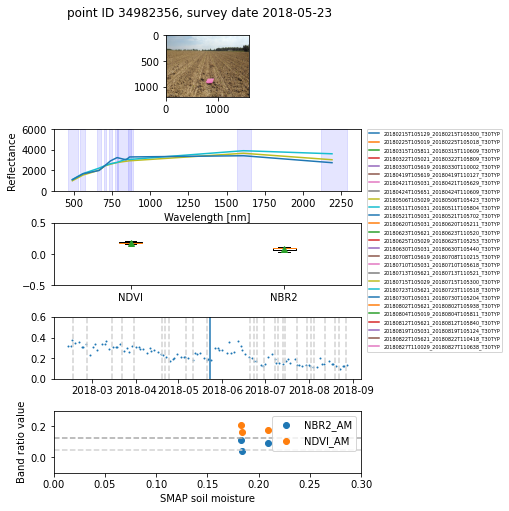

<Figure size 432x288 with 0 Axes>

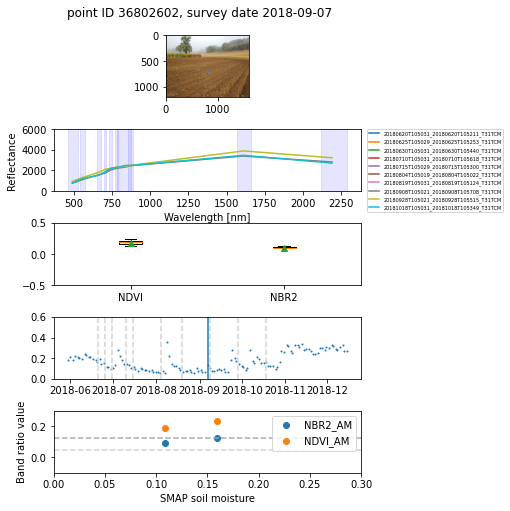

<Figure size 432x288 with 0 Axes>

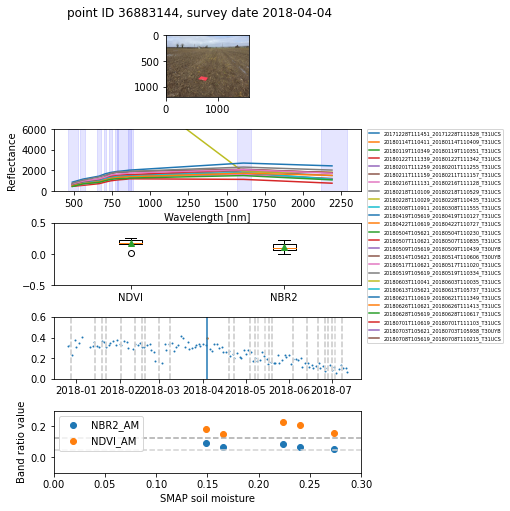

<Figure size 432x288 with 0 Axes>

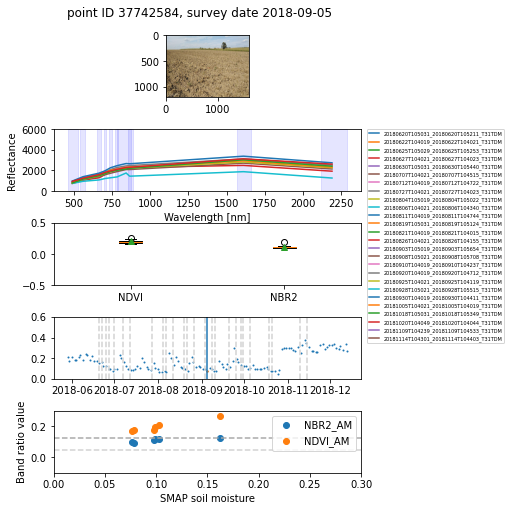

<Figure size 432x288 with 0 Axes>

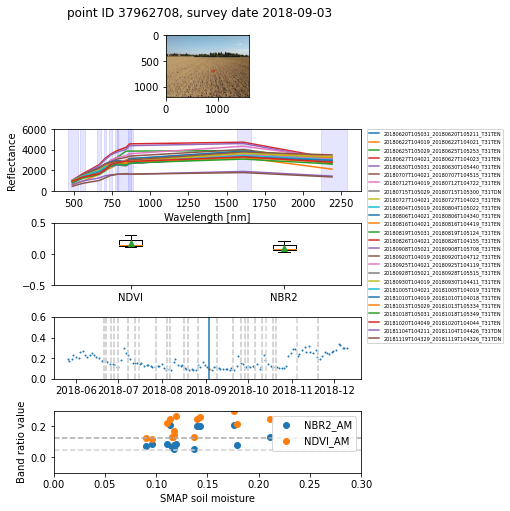

<Figure size 432x288 with 0 Axes>

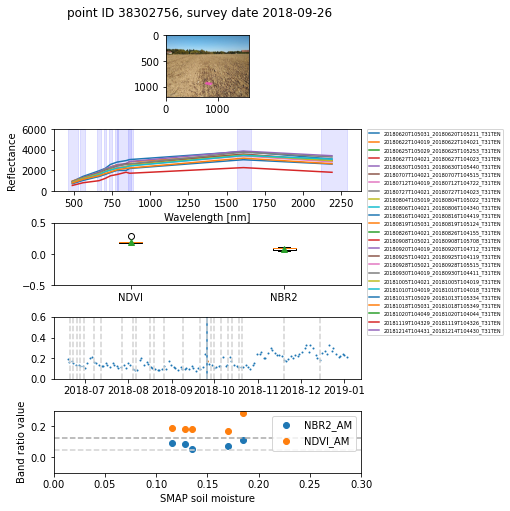

<Figure size 432x288 with 0 Axes>

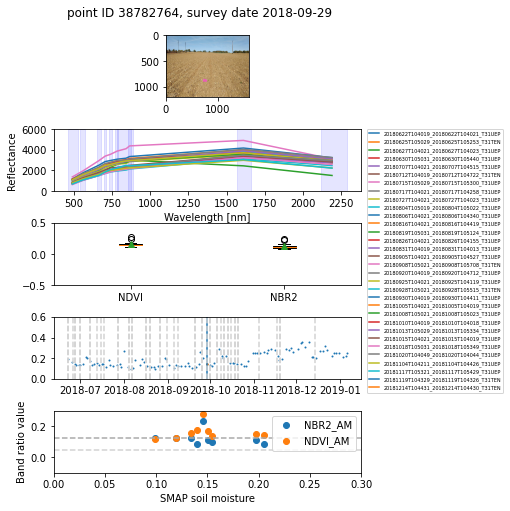

<Figure size 432x288 with 0 Axes>

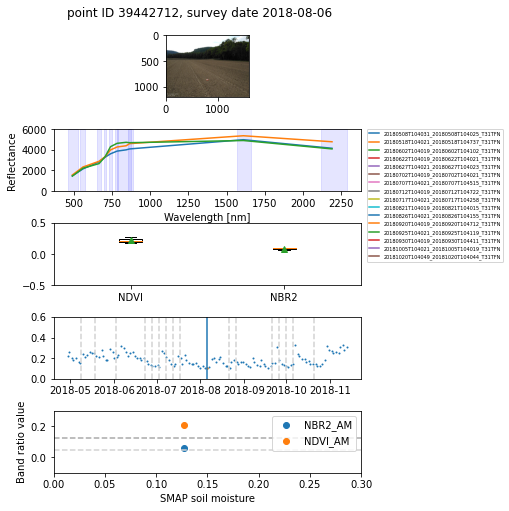

<Figure size 432x288 with 0 Axes>

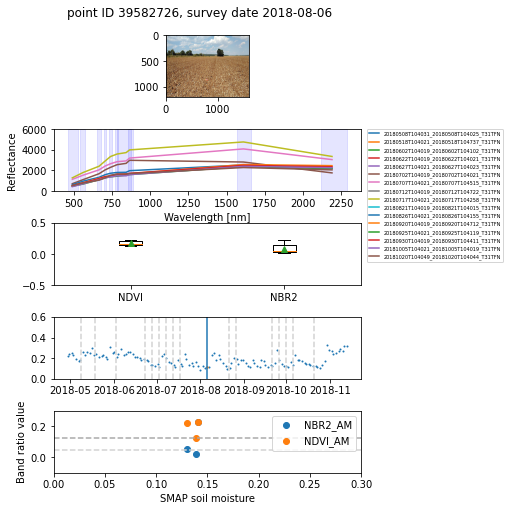

<Figure size 432x288 with 0 Axes>

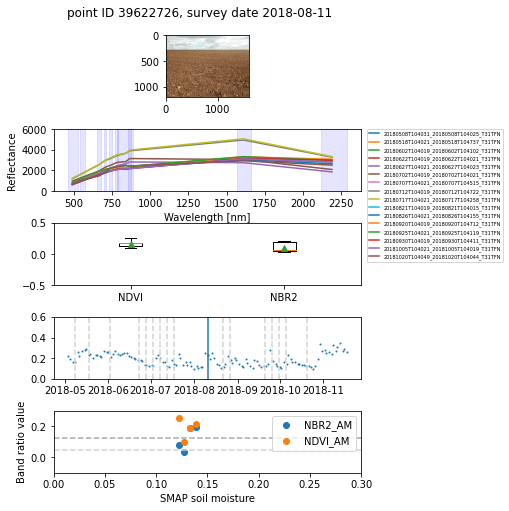

<Figure size 432x288 with 0 Axes>

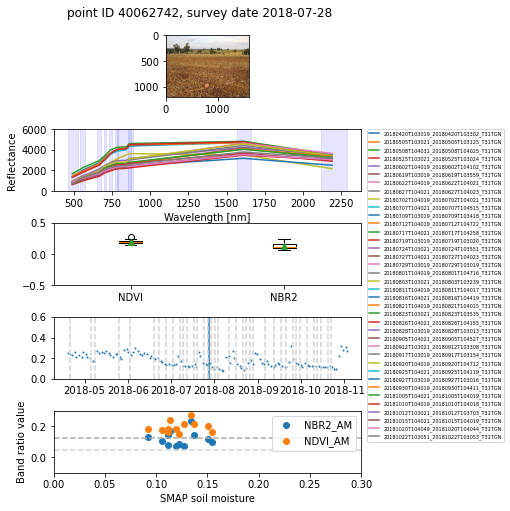

<Figure size 432x288 with 0 Axes>

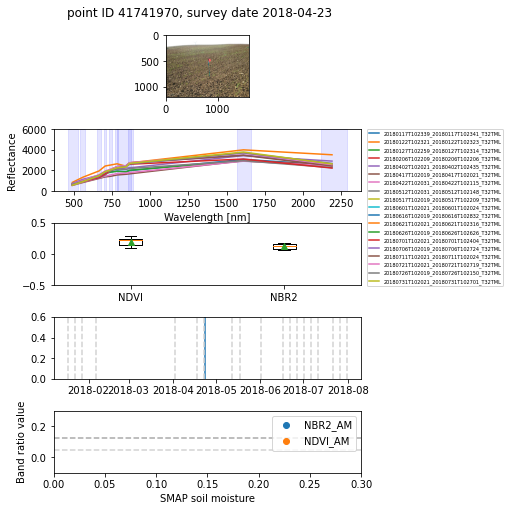

<Figure size 432x288 with 0 Axes>

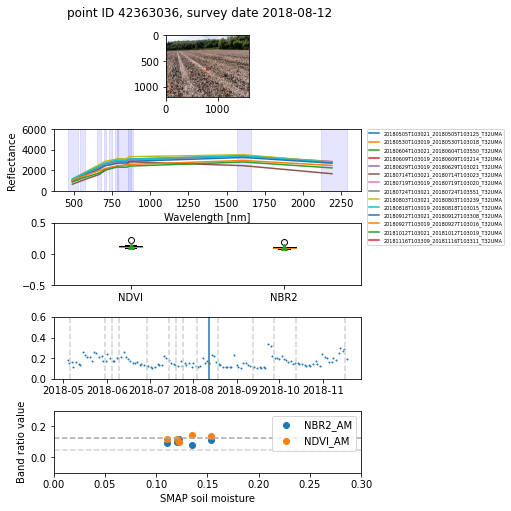

<Figure size 432x288 with 0 Axes>

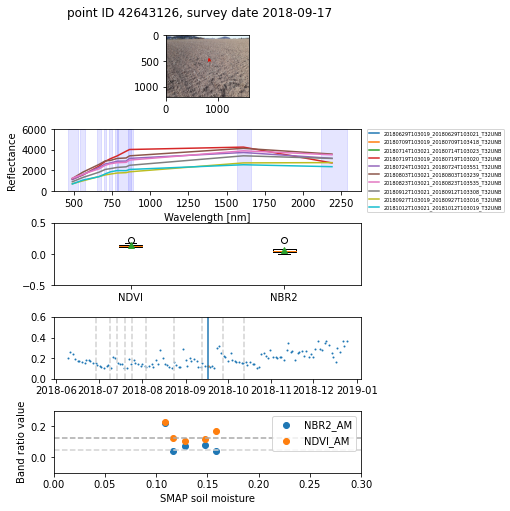

<Figure size 432x288 with 0 Axes>

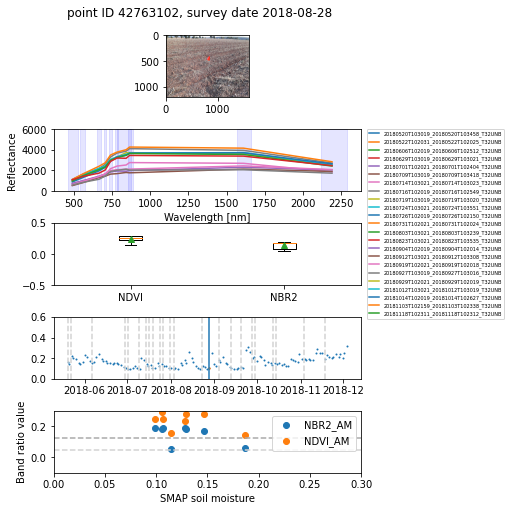

<Figure size 432x288 with 0 Axes>

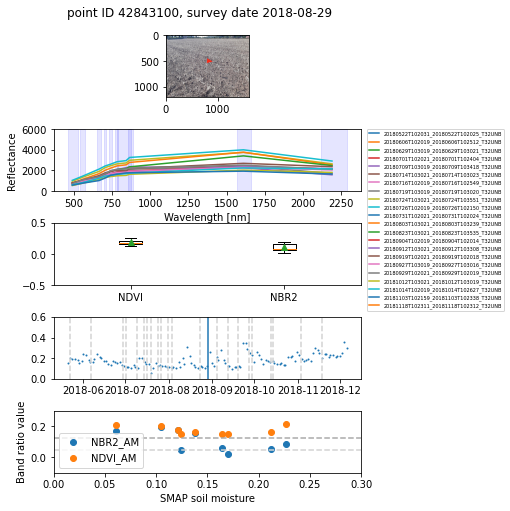

<Figure size 432x288 with 0 Axes>

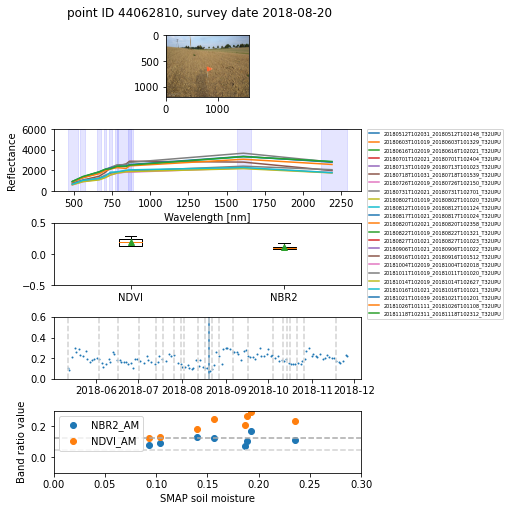

<Figure size 432x288 with 0 Axes>

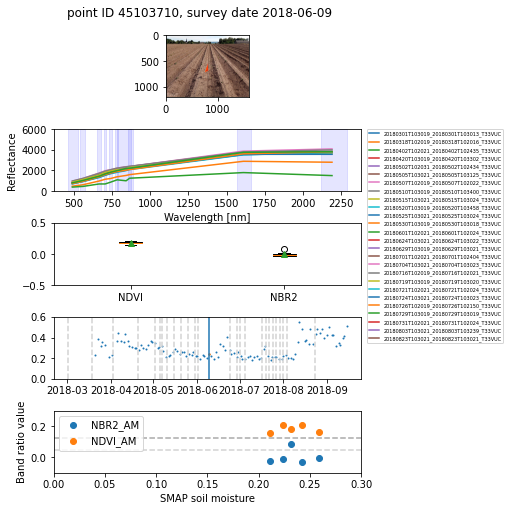

<Figure size 432x288 with 0 Axes>

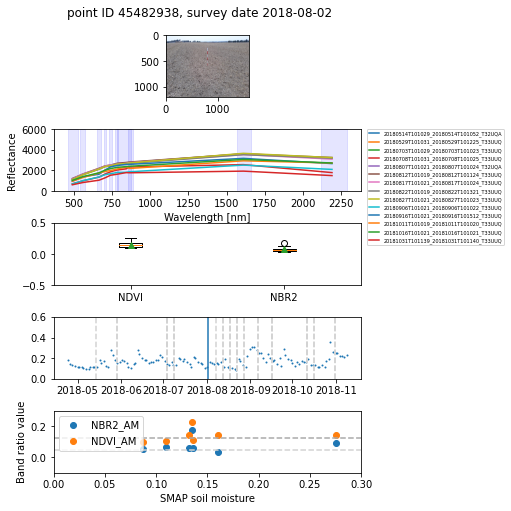

<Figure size 432x288 with 0 Axes>

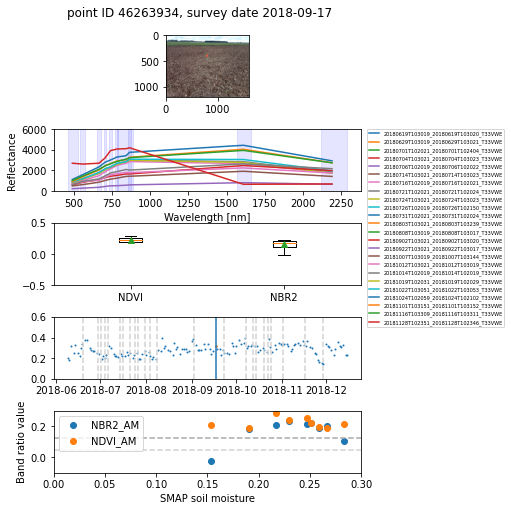

<Figure size 432x288 with 0 Axes>

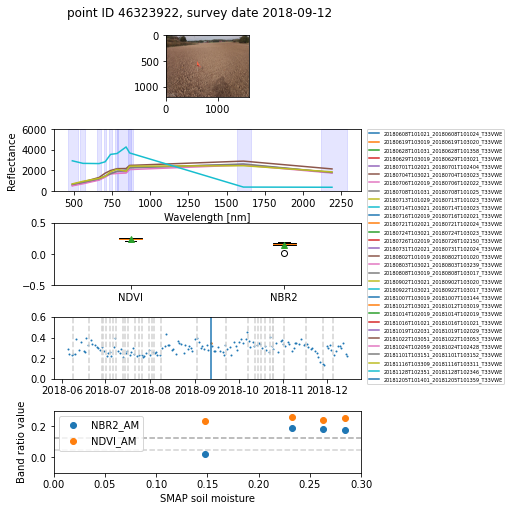

<Figure size 432x288 with 0 Axes>

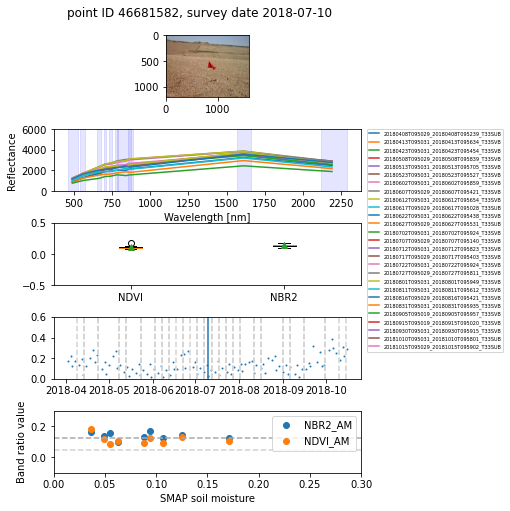

<Figure size 432x288 with 0 Axes>

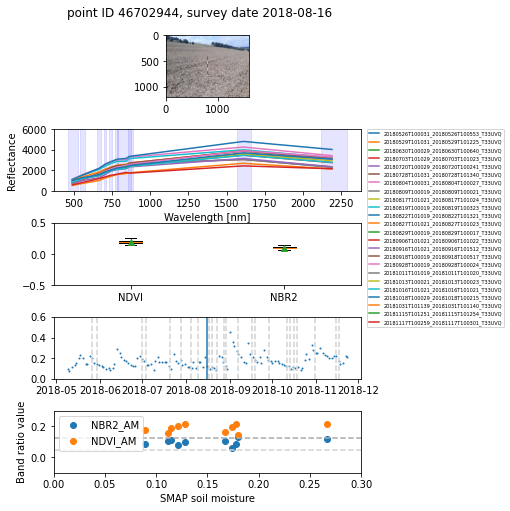

<Figure size 432x288 with 0 Axes>

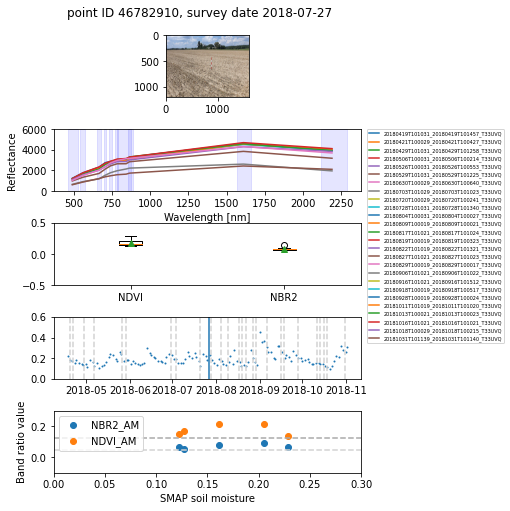

<Figure size 432x288 with 0 Axes>

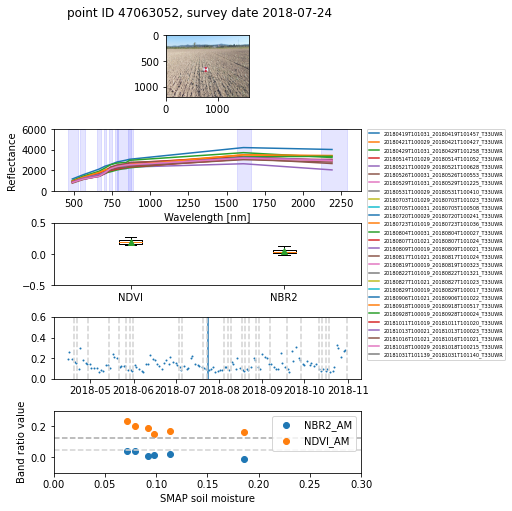

<Figure size 432x288 with 0 Axes>

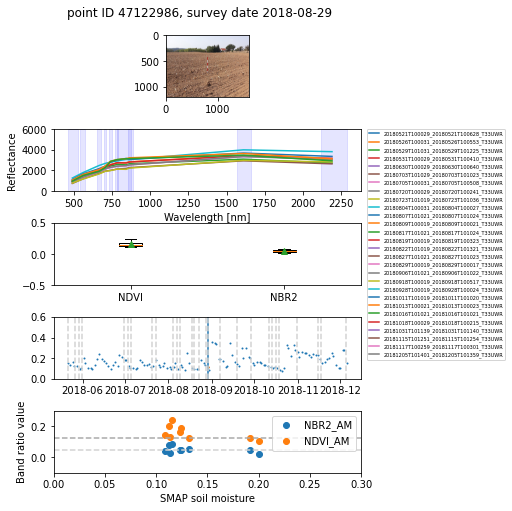

<Figure size 432x288 with 0 Axes>

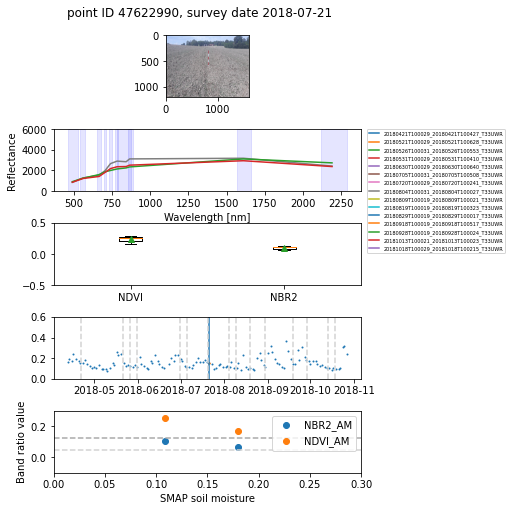

<Figure size 432x288 with 0 Axes>

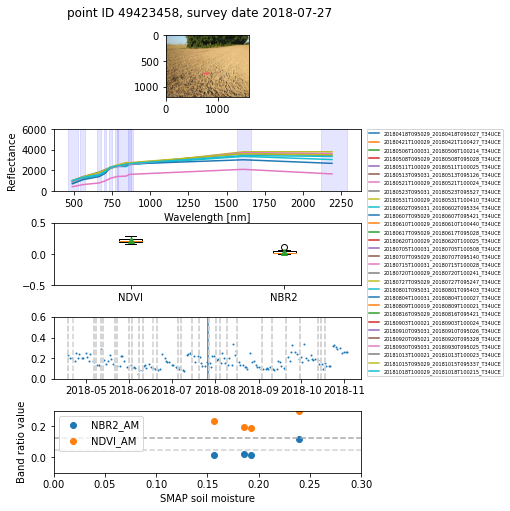

<Figure size 432x288 with 0 Axes>

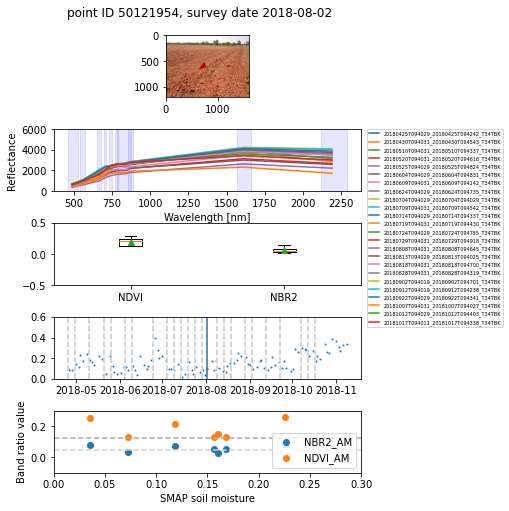

In [59]:
#inefficient code

#S2collection = ee.ImageCollection("COPERNICUS/S2_SR").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select (['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']).sort("system:time_start")
S2collection = S2joined_cloudfree.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select (['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']).sort("system:time_start")

infoo = []
infoodf = []
infoonew = []
infoSMAPP = []

wavelengths = [490,560,665,705,740,783,842,865,1610,2190] 

#limit = 2

PATH = 'Figgys/LUCAS2018Points_CM_residue'
if not os.path.exists(PATH):
    os.makedirs(PATH)
        
        
for ind in data_subsetbare.index:
    #Define useful parameters
    #---------------------------------------------------------------------------------------------------------
    pointID = data_subsetbare['POINT_ID'][ind]
    surveydate = data_subsetbare['newdate'][ind]
    SOC = data_subsetbare["SOC"][ind]
    LC = data_subsetbare["H_lc1_labe"][ind]
    soiltype = data_subsetbare["2015A_So_1"][ind]
    CR = data_subsetbare["Crop_resid"][ind]
    CR_LVL = data_subsetbare["Crop_level"][ind]
    R = data_subsetbare["Roughness"][ind]
    moist = data_subsetbare["soil_moist"][ind]
    crust = data_subsetbare["soil_crust"][ind]
    PHOTO=data_subsetbare["H_file_p_4"][ind]
    
    latind = data_subsetbare["H_gps_lat"][ind]
    lonind = data_subsetbare["H_gps_long"][ind]
    
    point = ee.Geometry.Point(lonind, latind)
    
    format = "%Y-%m-%d"
    dt_object = datetime.datetime.strptime(surveydate, format)
    
    delta = datetime.timedelta(days = 100)
    datemin = dt_object - delta
    datemax = dt_object + delta
    
    
    #apply S2 cloudless
    #----------------------------------------------------------------------------------------------------------
    
    CLOUD_FILTER = 60
    CLD_PRB_THRESH = 30
    NIR_DRK_THRESH = 0.15
    CLD_PRJ_DIST = 1
    BUFFER = 50
    
    S2collection = (ee.ImageCollection("COPERNICUS/S2_SR").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).filterBounds(point).filterDate(datemin, datemax).select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'SCL' ]).sort("system:time_start"))
    S2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY').filterBounds(point).filterDate(datemin, datemax))

    joined = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': S2collection,
        'secondary': S2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))
            
    def add_cloud_bands(img):
        # Get s2cloudless image, subset the probability band.
        cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

        # Condition s2cloudless by the probability threshold value.
        is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

        # Add the cloud probability layer and cloud mask as image bands.
        return img.addBands(ee.Image([cld_prb, is_cloud]))

    #define cloud shadow mask component 
    def add_shadow_bands(img):
        # Identify water pixels from the SCL band.
        not_water = img.select('SCL').neq(6)

        # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
        SR_BAND_SCALE = 1e4
        dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

        # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
        shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')))
    
        # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
        cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
            .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
            .select('distance')
            .mask()
            .rename('cloud_transform'))

        # Identify the intersection of dark pixels with cloud shadow projection.
        shadows = cld_proj.multiply(dark_pixels).rename('shadows')

        # Add dark pixels, cloud projection, and identified shadows as image bands.
        return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

    #function to add cloud and cloud shadow mask
    def add_cld_shdw_mask(img):
        # Add cloud component bands.
        img_cloud = add_cloud_bands(img)

        # Add cloud shadow component bands.
        img_cloud_shadow = add_shadow_bands(img_cloud)

        # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
        is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

        # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
        # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
        is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
            .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
            .rename('cloudmask'))

        # Add the final cloud-shadow mask to the image.
        return img_cloud_shadow.addBands(is_cld_shdw)

    def apply_cld_shdw_mask(img):
        # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
        not_cld_shdw = img.select('cloudmask').Not()

        # Subset reflectance bands and update their masks, return the result.
        return img.select('B.*').updateMask(not_cld_shdw)

    S2joined = joined.map(add_cld_shdw_mask)
    S2joined_cloudfree = S2joined.map(apply_cld_shdw_mask)                  
        
        
        
    #add NDVI and NBR2 bands
    #---------------------------------------------------------------------------------------------
    
    def addNDVI(image):
        return image.addBands(image.normalizedDifference(['B8', 'B4']).rename('ndvi'))

    
    def addNBR2(image):
        return image.addBands(image.normalizedDifference(['B11', 'B12']).rename('nbr2'))
    #S2collection = S2collection.map(addNDVI)
    S2collection = S2joined_cloudfree.map(addNDVI).map(addNBR2)
    
    
    #threshold the NDVI
    def ndviThres(image):
        #threshold: if NDVI less or equal to 0.3 => 1 else 0
        thres = image.select(['ndvi']).lte(0.3).rename('ndvi_thres')
        return image.addBands(thres)

    S2coll = S2collection.map(ndviThres)
    
    def mask1(image):
        return image.updateMask(image.select('ndvi_thres'))
    
    S2colll= S2coll.map(mask1)
    
    #this is a list of dates S2 images were taken...
    dates = S2colll.aggregate_array("system:time_start").getInfo()
    datess=[]
    for i in dates:
        date = datetime.datetime.fromtimestamp(i//1000.0)
        datess.append(date)
        
    #print(datess)
    
  
    SMAP = ee.ImageCollection('NASA/SMAP/SPL3SMP_E/005').filterBounds(point).filterDate(datemin, datemax).select(['soil_moisture_am', "soil_moisture_pm"])
    #SMAPPM = ee.ImageCollection('NASA/SMAP/SPL3SMP_E/005').filterBounds(point).filterDate(datemin, datemax).select('soil_moisture_pm')
    JAXA_GPM = ee.ImageCollection('JAXA/GPM_L3/GSMaP/v6/operational').filterBounds(point).filterDate(datemin, datemax).select('hourlyPrecipRate')
    
    
    # Get info from the point
    #------------------------------------------------------------------------------------------------------------
    #try S2collection for no applied NDVI mask
    info = S2colll.getRegion(point,20).getInfo() # change collection by series
    
    infoSMAP = SMAP.getRegion(point,900).getInfo()
    #infoSMAPPM = SMAPPM.getRegion(point,900).getInfo()
    infoJAXA = JAXA_GPM.getRegion(point,500).getInfo()
    
    #print(infoSMAP)
    
    SMAPdf = pd.DataFrame(infoSMAP[1:], columns =infoSMAP[0])
    
    #print(infoJAXA)
    df = pd.DataFrame(info[1:], columns =info[0]) 
    
    
    dates = S2colll.aggregate_array("system:time_start").getInfo()
    datess=[]
    for i in dates:
        date = datetime.datetime.fromtimestamp(i//1000.0)
        datess.append(date)
        
    #not intended output
    #df["time"] = pd.to_timedelta(df.time)
    df["time"] =  pd.to_datetime(df['time'], unit='ms').dt.floor('D')
    
    
    df["pointID"] = pointID
    df["surveydate"] = surveydate
    df["SOC"] = SOC
    df["LC"] = LC
    df["soiltype"] = soiltype
    df["CR"] = CR
    df["crust"] = crust
    df["latind"] = latind
    df["lonind"] = lonind
    #df["moisture"] = SMAPdf['soil_moisture_am']
    
    SMAPdf["pointID"] = pointID
    SMAPdf["surveydate"] = surveydate
    SMAPdf['date'] =  pd.to_datetime(SMAPdf['id'], format='%Y%m%d')

    
    #save external to loop
    #------------------------------------------------------------------------------------------------------------
  
    infoo.append(info)
    infoodf.append(df)
    infoSMAPP.append(SMAPdf)
    
    #rename band names with the S2 central wavelength
    df.rename(columns={'B2':490, 'B3':560,'B4':665,'B5':705, 'B6':740, 'B7':783, 'B8':842, 'B8A':865, 'B11':1610, 'B12':2190}, inplace=True)
    
    df = df.drop_duplicates(subset=['time'], keep='last')
    reflectance =df.iloc[:, 4:].T

    #Map visualisation (does not work)
    #----------------------------------------------------------------------------------------------------------------------------------------------
    #firsta = S2colll.first()
    #Image(url=firsta.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    
    #def plotfunc (image):
        #Image(url=image.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    #S2colll.map(plotfunc)
    
    #Image(url=i.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    
    #print(type(firsta)) ee.Image... how to plot?? Ask Andrew...
    #Image(url=first.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
        
    """  
    def plotfunc (image):
        Image(url=image.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    
    S2colll.map(plotfunc)
    """
    
    #LUCAS PICTURE DATABSE PHOTO STUFF
    #---------------------------------------------------------------------------------------------------------------
    url = PHOTO
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))

    plt.figure() #figsize=(10,30))
    
    #fig, (ax1, ax2,ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [24,18,15]}) #also try: height_ratios=[1, 3, 1]
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1,  figsize=(5,7)) 
    
    #try adding inside brackets gridspec_kw={'height_ratios': [4,4]}
    #also try: height_ratios=[1, 3, 1]
    
    fig.suptitle("point ID "+ str(pointID)+ ", survey date "+ str(surveydate))
    fig.tight_layout()

    
    #PLOT EVERYTHING
    ax1.imshow(img)
    
    
    #add a plot that is basically a timeseries of SMAP soil moisture for selected time interval... 
    cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

    ax2.plot(df.loc[:, 490: 2190].T, label=df.loc[:,"id"])
    ax2.set_ylim([0, 6000])
    ax2.legend(prop={'size':5}, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    
    ax2.set(xlabel="Wavelength [nm]", ylabel="Reflectance")
    ax2.axvspan(459.5, 524, color="blue", alpha=0.1)     #B2
    ax2.axvspan(541.5, 575.5, color="blue", alpha=0.1)   #B3
    ax2.axvspan(649, 679, color="blue", alpha=0.1)       #B4
    ax2.axvspan(779.5, 884.5, color="blue", alpha=0.1)   #B8
    ax2.axvspan(697, 711, color="blue", alpha=0.1)       #B5
    ax2.axvspan(733, 747, color="blue", alpha=0.1)       #B6
    ax2.axvspan(772.5, 791.5, color="blue", alpha=0.1)   #B7
    ax2.axvspan(853.5, 874.5, color="blue", alpha=0.1)   #B8a
    ax2.axvspan(1568, 1658, color="blue", alpha=0.1)     #B11
    ax2.axvspan(2115, 2289, color="blue", alpha=0.1)     #B12
    
    
    #Boxplots, too
    data = df["ndvi"].dropna(), df["nbr2"].dropna()

    # Creating plot
    ax3.boxplot(data, showmeans = True)
    ax3.set_ylim([-0.5, 0.5])
    ax3.set_xticklabels(['NDVI', 'NBR2'])
    
    
    ax4.axvline(x=dt_object)
    for i in datess:
        ax4.axvline(x=i, color = "lightgray", linestyle="dashed")
    ax4.scatter(SMAPdf["date"], SMAPdf["soil_moisture_am"], s=1)
    #ax4.scatter(SMAPdf["date"], SMAPdf["soil_moisture_pm"], s=1)
    dfdate = SMAPdf[SMAPdf["date"]  == dt_object]
    ax4.scatter(dfdate["date"], dfdate["soil_moisture_am"], s= 2)
    #ax4.scatter(dfdate["date"], dfdate["soil_moisture_pm"], s= 2)
    ax4.set_ylim([0, 0.6])
    
    
    #ADD LAST PLOT where x is the NBR2 threshold, y is the SMAP soil moisture... 
    #print(SMAPdf["date"])
    #print(df["time"])
    
    SMAPdf2 = SMAPdf[SMAPdf['date'].isin(df['time'])]
    #print(SMAPdf2)
    #print(df)
    #print(SMAPdf2["soil_moisture_am"])
    x = SMAPdf2["soil_moisture_am"]
    x2 = SMAPdf2["soil_moisture_pm"]
    y = df["nbr2"]
    y2 = df["ndvi"]
    #print(x.shape) #25  2018-06-26 is doubled in NBR2... WHY IS THIS?
    #print(y.shape) #24
    ax5.scatter(x, y, label= "NBR2_AM")
    ax5.scatter(x, y2, label = "NDVI_AM")
    #ax5.scatter(x2, y, label= "NBR2_PM")
    #ax5.scatter(x2, y2, label = "NDVI_PM")
    
    ax5.axhline(y = 0.05, color="lightgray", linestyle = "dashed")
    #ax5.text(0.05, 0, "Dvorakova et al. 2023")
    ax5.axhline(y = 0.125, color="darkgray", linestyle = "dashed")
    #ax5.text(0.125, 0, "Castaldi et al. 2023")
    
    ax5.set(xlabel="SMAP soil moisture", ylabel="Band ratio value")
    ax5.set_ylim([-0.1, 0.3])
    ax5.set_xlim([0, 0.3])
    ax5.legend()
    
    filename = str(pointID) +'.png'
    

    
    plt.savefig(PATH + "/"+ filename, format='png', dpi=200, bbox_inches="tight")
   
    #dftest = pd.concat([df, SMAPdf], axis=1)
    #dftest['result'] = np.where(dftest['time'] == df['date'], 'match', 'no match')
    #if df["time"] == SMAPdf["date"]:
        #plt.scatter(df["nbr2"], SMAPdf["soil_moisture_am"])
    
        #plt.close()
    """
    if not pd.isnull(df.loc[2, 490]):
        ax2.plot(df.loc[:, 490: 2190].T, label=df.loc[:,"id"])
        ax2.set_ylim([0, 6000])
        ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        #axes2.set(xlabel="Exam score-1", ylabel="Exam score-2")
        ax2.set(xlabel="Wavelength [nm]", ylabel="Reflectance")
        ax2.axvspan(459.5, 524, color="blue", alpha=0.1)     #B2
        ax2.axvspan(541.5, 575.5, color="blue", alpha=0.1)   #B3
        ax2.axvspan(649, 679, color="blue", alpha=0.1)       #B4
        ax2.axvspan(779.5, 884.5, color="blue", alpha=0.1)   #B8
        ax2.axvspan(697, 711, color="blue", alpha=0.1)       #B5
        ax2.axvspan(733, 747, color="blue", alpha=0.1)       #B6
        ax2.axvspan(772.5, 791.5, color="blue", alpha=0.1)   #B7
        ax2.axvspan(853.5, 874.5, color="blue", alpha=0.1)   #B8a
        ax2.axvspan(1568, 1658, color="blue", alpha=0.1)     #B11
        ax2.axvspan(2115, 2289, color="blue", alpha=0.1)     #B12
   
    
    
    
    #check this out: https://gis.stackexchange.com/questions/342022/trouble-plotting-earth-engine-images-with-folium-using-python
    plt.rc('font', size=20)
    plt.rc('legend', fontsize=15) #fontsize of the legend

    #plt.figure(figsize=(20,10))
    axes = plt.axes()
    
    #plt.plot(df.loc[:, 490: 2190].T, label=df.loc[:,"id"])
    plt.axvspan(459.5, 524, color="blue", alpha=0.1)     #B2
    plt.axvspan(541.5, 575.5, color="blue", alpha=0.1)   #B3
    plt.axvspan(649, 679, color="blue", alpha=0.1)       #B4
    plt.axvspan(779.5, 884.5, color="blue", alpha=0.1)   #B8
    plt.axvspan(697, 711, color="blue", alpha=0.1)       #B5
    plt.axvspan(733, 747, color="blue", alpha=0.1)       #B6
    plt.axvspan(772.5, 791.5, color="blue", alpha=0.1)   #B7
    plt.axvspan(853.5, 874.5, color="blue", alpha=0.1)   #B8a
    plt.axvspan(1568, 1658, color="blue", alpha=0.1)     #B11
    plt.axvspan(2115, 2289, color="blue", alpha=0.1)     #B12
    # Show/save figure as desired.
   
    #ax2.title("point ID "+ str(pointID)+ ", survey date "+ str(surveydate))
    #ax2.xlabel("Wavelength [nm]")
    #ax2.ylabel("Reflectance")
    #axes.set_ylim([0, 6000])
    #ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    
    df["pointID"] = pointID
    df["surveydate"] = surveydate
    df["SOC"] = SOC
    df["LC"] =  LC
    df["soiltype"] =soiltype
    df["CR"] = CR
    df["CR_LVL"] = CR_LVL
    df["R"] = R
    df["moist"]= moist 
    df["crust"] =crust 
    
    infoonew.append(df)
    #plt.figure()
    #plt.plot(wavelength, refelctance)
    # Show/save figure as desired.
    #plt.show()

#create a "nested" dataframe e.g. in subsetbare, for each row save the reflectance values for each mage within 6-week period
#

"""


In [9]:
#how to read a series of tiffs and extract value by point
import rasterio
import geopandas as gpd


print(infoodf)
# Read points from shapefile
#pts = gpd.read_file('your_point_shapefile.shp')
#pts = pts[['UTM_E', 'UTM_N', 'Value', 'geometry']]
#pts.index = range(len(pts))

"""
coords = [(x,y) for x, y in zip(pts.UTM_E, pts.UTM_N)]

coords = [H_lat, H_long]

# Open the raster and store metadata
src = rasterio.open('your_raster.tif')

# Sample the raster at every point location and store values in DataFrame
pts['Raster Value'] = [x for x in src.sample(coords)]
pts['Raster Value'] = probes.apply(lambda x: x['Raster Value'][0], axis=1)
"""

NameError: name 'infoodf' is not defined

In [21]:
print(infoodf[0])
print(infoSMAPP)

concatdf = pd.concat(infoodf, infoSMAPP, axis=1)
print(concatdf)
""""
for i in infoSMAPP:
    #fig.suptitle("point ID "+ str(pointID)+ ", survey date "+ str(surveydate))
    plt.figure()
    plt.scatter(i["id"], i["soil_moisture_am"])
    #plt.suptitle[i["pointID"][0]]
    plt.show()
    



for i in infoodf:
    print (i["pointID"][0],  "NDVI", i["ndvi"].mean(), " NBR2", i["nbr2"].mean(), i["LC"][0], i["surveydate"][0])
    #print("stdev: ", i["nbr2"].std())
 
    lista.append(i["pointID"][0])
    lista.append(i["ndvi"].mean())
    lista.append(i["nbr2"].mean())

#infotest = pd.DataFrame(infoo, columns = infoo[0][0])
"""
#print(infoodf)

#type
#SMAPdf = pd.DataFrame(infoSMAP[1:], columns =infoSMAP[0])
#SMAPdf

#infoodf =pd.DataFrame(infoodf[1:], columns =infoodf[0])
#for i infoodf:
    

                                        id  longitude   latitude       time  \
0   20180221T111049_20180221T111202_T30TWT  -1.729526  46.976769 2018-02-21   
1   20180226T111011_20180226T111426_T30TWT  -1.729526  46.976769 2018-02-26   
2   20180318T110801_20180318T110755_T30TWT  -1.729526  46.976769 2018-03-18   
3   20180320T105739_20180320T110436_T30TWT  -1.729526  46.976769 2018-03-20   
4   20180417T110651_20180417T110822_T30TWT  -1.729526  46.976769 2018-04-17   
5   20180419T105619_20180419T110127_T30TWT  -1.729526  46.976769 2018-04-19   
6   20180424T105651_20180424T110609_T30TWT  -1.729526  46.976769 2018-04-24   
7   20180504T105621_20180504T110230_T30TWT  -1.729526  46.976769 2018-05-04   
8   20180507T110621_20180507T110835_T30TWT  -1.729526  46.976769 2018-05-07   
9   20180519T105619_20180519T110334_T30TWT  -1.729526  46.976769 2018-05-19   
10  20180524T110041_20180524T110036_T30TWT  -1.729526  46.976769 2018-05-24   
11  20180621T110619_20180621T111349_T30TWT  -1.72952

/var/folders/96/nqm4g9gx5fbfn4hd2ppmp12w0000gn/T/ipykernel_20106/2847788161.py:4: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  concatdf = pd.concat(infoodf, infoSMAPP, axis=1)


TypeError: concat() got multiple values for argument 'axis'

In [ ]:
#pip install pandas-geojson

#S2collection = ee.ImageCollection("COPERNICUS/S2_SR").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select (['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']).sort("system:time_start")
S2collection = S2joined_cloudfree.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select (['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']).sort("system:time_start")

geo_json = to_geojson(df= data_subsetbare, lat="H_gps_lat", lon="H_gps_long",
                 properties=['field_1', 'POINT_ID', 'H_survey_d', 'H_lc1_labe', 'Remark', 'Crop_resid', 'Crop_level', 'Roughness', 'ID', 'H_point_id', 'H_nuts0', 'H_nuts1', 'H_nuts2', 'H_nuts3', 'H_th_lat', 'H_th_long', 'H_gps_proj', 'H_gps_prec', 'H_gps_alti', 'H_gps_lat', 'H_gps_ew', 'H_gps_long', 'H_obs_dist', 'H_obs_dire', 'H_obs_type', 'H_letter_g', 'H_lc1', 'H_lc1_spec', 'H_lc1_sp_1', 'H_lc1_perc', 'H_lc2', 'H_lc2_labe', 'H_lu1', 'H_lu1_labe', 'H_parcel_a', 'H_lm_stone', 'H_grazing', 'H_special_', 'H_lc_lu_sp', 'H_cprn_lc', 'H_cprn_lc_', 'H_wm', 'H_wm_sourc', 'H_wm_type', 'H_wm_deliv', 'H_erosion_', 'H_soil_sto', 'H_bio_samp', 'H_soil_bio', 'H_bulk0_10', 'H_soil_blk', 'H_bulk10_2', 'H_soil_b_1', 'H_bulk20_3', 'H_soil_b_2', 'H_standard', 'H_soil_std', 'H_organic_', 'H_soil_org', 'H_soil_tak', 'H_soil_cro', 'H_transect', 'H_revisit', 'H_th_gps_d', 'H_file_pat', 'H_file_p_1', 'H_file_p_2', 'H_file_p_3', 'H_file_p_4', '20m to bor', 'soil_moist', 'soil_crust', 'Depth', 'PointID', 'pH(CaCl2)', 'pH(H2O)', 'EC', 'OC', 'CaCO3', 'P', 'N', 'K', 'OC (20-30c', 'CaCO3 (20-', 'Ox_Al', 'Ox_Fe', 'SURVEY_DAT', 'Elev', '2015_Coars', '2015_Clay', '2015_Sand', '2015_Silt', '2015_OC', '2015_LC0_D', '2015_LC1_D', '2015_LU1_D', '2015_lette', '2015_lc1', '2015_lc1_l', '2012_lette', '2012_lc1', '2012_lc1_l', '2009_lette', '2009_lc1', '2009_lc1_l', '2006_lette', '2006_lc1', '2006_lc1_l', '2015A_CLIM', '2015A_Elev', '2015A_Slop', '2015A_Aspe', '2015A_BioG', '2015A_Soil', '2015A_So_1', '2015A_BIO1', '2015A_BIO2', '2015A_BIO3', '2015A_BIO4', '2015A_BIO5', '2015A_BIO6', '2015A_BIO7', '2015A_BIO8', '2015A_BIO9', '2015A_BI_1', '2015A_BI_2', '2015A_BI_3', '2015A_BI_4', '2015A_BI_5', '2015A_BI_6', '2015A_BI_7', '2015A_BI_8', '2015A_BI_9', '2015A_BI10', 'SOC', 'newdate'])
#print(geo_json)

data = ee.FeatureCollection(geo_json)


In [8]:
#S2collection = ee.ImageCollection("COPERNICUS/S2_SR").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select (['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']).sort("system:time_start")
S2collection = S2joined_cloudfree.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select (['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']).sort("system:time_start")

infoo = []
infoodf = []
infoonew = []


wavelengths = [490,560,665,705,740,783,842,865,1610,2190]    


#define some stuff
def addNDVI(image):
    return image.addBands(image.normalizedDifference(['B8', 'B4']).rename('ndvi'))

def addNBR2(image):
    return image.addBands(image.normalizedDifference(['B11', 'B12']).rename('nbr'))


#S2collection = S2collection.map(addNDVI)
S2collection = S2joined_cloudfree.map(addNDVI).map(addNBR2)
    
def ndviThres(image):
    #threshold: if NDVI less or equal to 0.3 => 1 else 0
    thres = image.select(['ndvi']).lte(0.35).rename('ndvi_thres')
    return image.addBands(thres)

S2coll = S2collection.map(ndviThres)
    
def mask1(image):
    return image.updateMask(image.select('ndvi_thres'))
    
S2colll= S2coll.map(mask1)

#print(S2colll)




def magical_func(row):
    
    #Define useful parameters
    #---------------------------------------------------------------------------------------------------------
    
    pointID = row.get('POINT_ID')
    surveydate = row.get('newdate')
    SOC = row.get("SOC")
    LC = row.get("H_lc1_labe")
    soiltype = row.get("2015A_So_1")
    CR = row.get("Crop_resid")
    CR_LVL = row.get("Crop_level")
    R = row.get("Roughness")
    moist = row.get("soil_moist")
    crust = row.get("soil_crust")
    PHOTO = row.get("H_file_p_4")
    
    latind = row.get("H_gps_lat")
    lonind = row.get("H_gps_long")
    
    point = ee.Geometry.Point(lonind, latind)
    
    format = "%Y-%m-%d"
    #dt_object = datetime.datetime.strptime(surveydate, format)
    
    dT_object = ee.Date(surveydate)
    delta = datetime.timedelta(days = 100)
    datemin = dt_object - delta
    datemax = dt_object + delta
    
    
    #filter the collection by date
    S2collll = (S2colll.filterBounds(point).filterDate(datemin, datemax))
    
    # Get info from the point
    #------------------------------------------------------------------------------------------------------------
    #try S2collection for no applied NDVI mask
    info = S2collll.getRegion(point,500)
    
    
    return infoo # change collection by series
    """
    df = pd.DataFrame(info[1:], columns =info[0])
    #print(info)
    

    infoo.append(info)
    infoodf.append(df)
    
    #rename band names with the S2 central wavelength
    df.rename(columns={'B2':490, 'B3':560,'B4':665,'B5':705, 'B6':740, 'B7':783, 'B8':842, 'B8A':865, 'B11':1610, 'B12':2190}, inplace=True)

    reflectance =df.iloc[:, 4:].T
    
    
    
    return infoo, infoodf
    
    #rename band names with the S2 central wavelength
    df.rename(columns={'B2':490, 'B3':560,'B4':665,'B5':705, 'B6':740, 'B7':783, 'B8':842, 'B8A':865, 'B11':1610, 'B12':2190}, inplace=True)

    reflectance =df.iloc[:, 4:].T

    #calculate band ratios (NBR2 and NDVI!!) 
    firsta = S2colll.first()
    
    plt.rc('font', size=20)
    plt.rc('legend', fontsize=15) #fontsize of the legend

    plt.figure(figsize=(20,10))
    axes = plt.axes()
    
    plt.plot(df.loc[:, 490: 2190].T, label=df.loc[:,"id"])
    plt.axvspan(459.5, 524, color="blue", alpha=0.1)     #B2
    plt.axvspan(541.5, 575.5, color="blue", alpha=0.1)   #B3
    plt.axvspan(649, 679, color="blue", alpha=0.1)       #B4
    plt.axvspan(779.5, 884.5, color="blue", alpha=0.1)   #B8
    plt.axvspan(697, 711, color="blue", alpha=0.1)       #B5
    plt.axvspan(733, 747, color="blue", alpha=0.1)       #B6
    plt.axvspan(772.5, 791.5, color="blue", alpha=0.1)   #B7
    plt.axvspan(853.5, 874.5, color="blue", alpha=0.1)   #B8a
    plt.axvspan(1568, 1658, color="blue", alpha=0.1)     #B11
    plt.axvspan(2115, 2289, color="blue", alpha=0.1)     #B12
    # Show/save figure as desired.
    plt.title("point ID "+ str(pointID)+ ", survey date "+ str(surveydate))
    plt.xlabel("Wavelength [nm]")
    plt.ylabel("Reflectance")
    axes.set_ylim([0, 6000])
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    
    df["pointID"] = pointID
    df["surveydate"] = surveydate
    df["SOC"] = SOC
    df["LC"] =  LC
    df["soiltype"] =soiltype
    df["CR"] = CR
    df["CR_LVL"] = CR_LVL
    df["R"] = R
    df["moist"]= moist 
    df["crust"] =crust 
    
    infoonew.append(df)
    

    """

S2collll = data.map(magical_func)

S2collll

#print(infoo)

/var/folders/96/nqm4g9gx5fbfn4hd2ppmp12w0000gn/T/ipykernel_80870/1206153641.py:282: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure() #figsize=(10,30))


<Figure size 432x288 with 0 Axes>

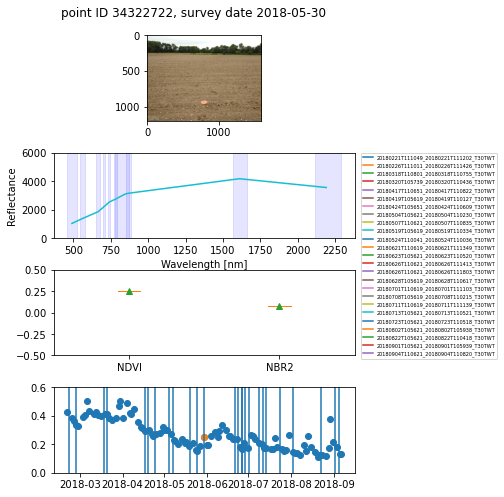

<Figure size 432x288 with 0 Axes>

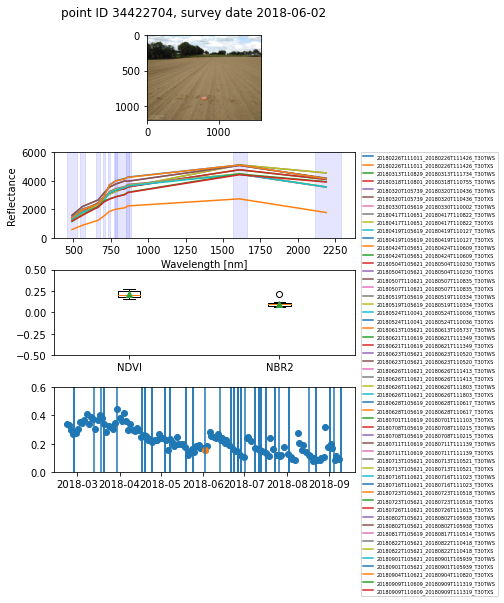

<Figure size 432x288 with 0 Axes>

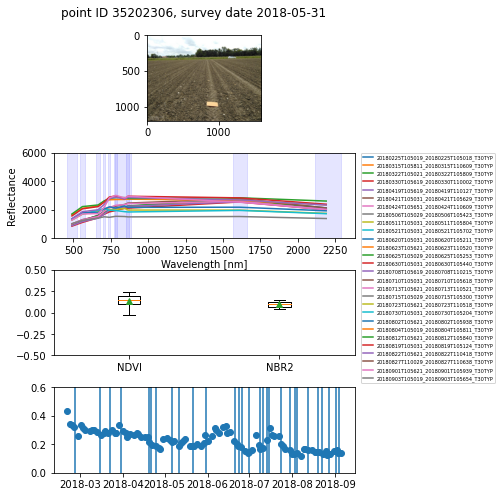

<Figure size 432x288 with 0 Axes>

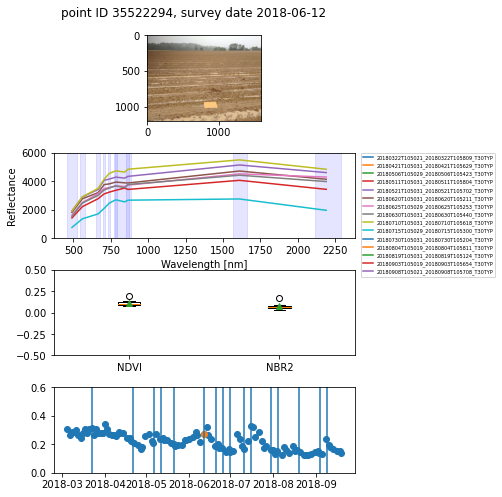

<Figure size 432x288 with 0 Axes>

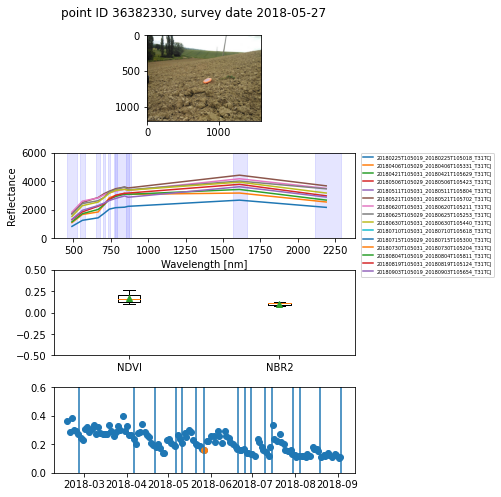

<Figure size 432x288 with 0 Axes>

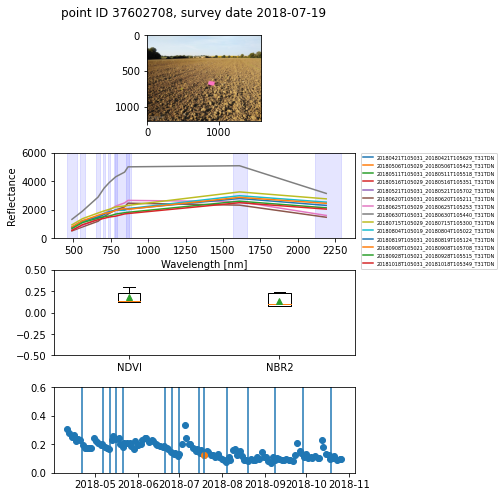

<Figure size 432x288 with 0 Axes>

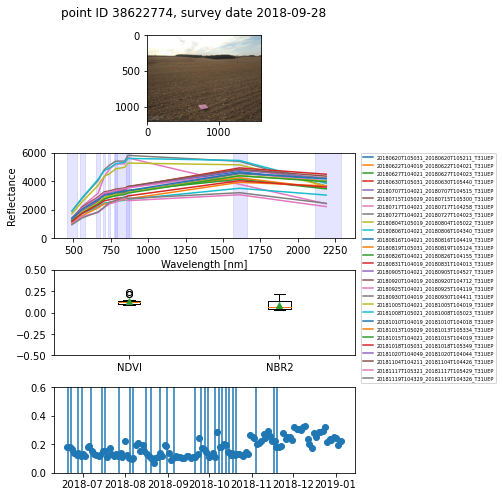

<Figure size 432x288 with 0 Axes>

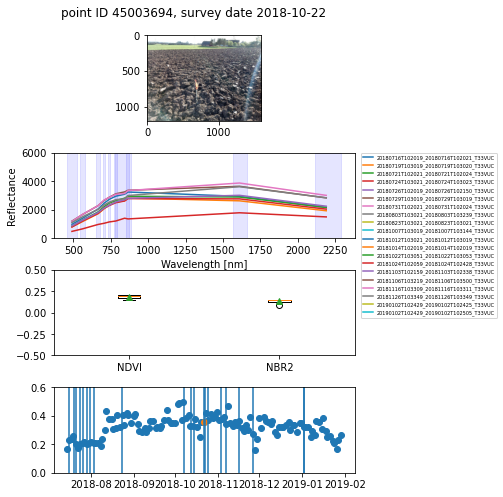

<Figure size 432x288 with 0 Axes>

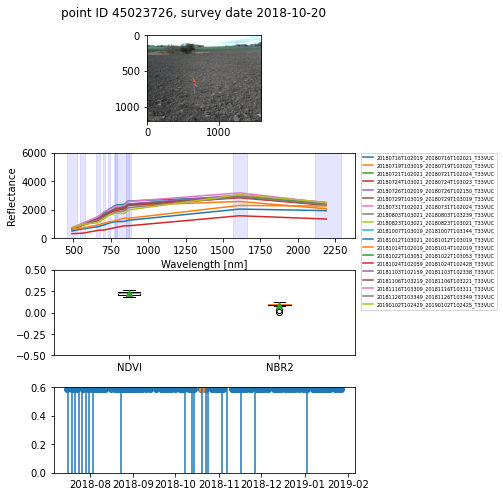

<Figure size 432x288 with 0 Axes>

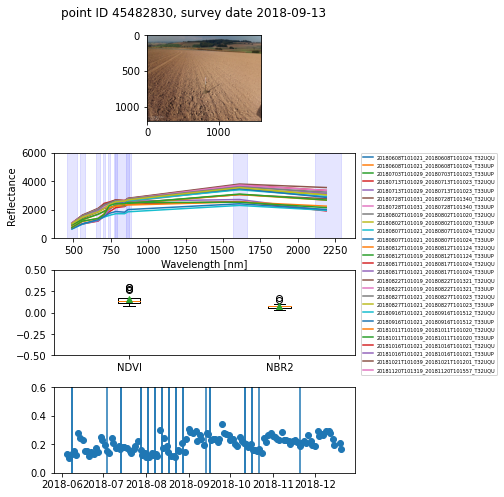

<Figure size 432x288 with 0 Axes>

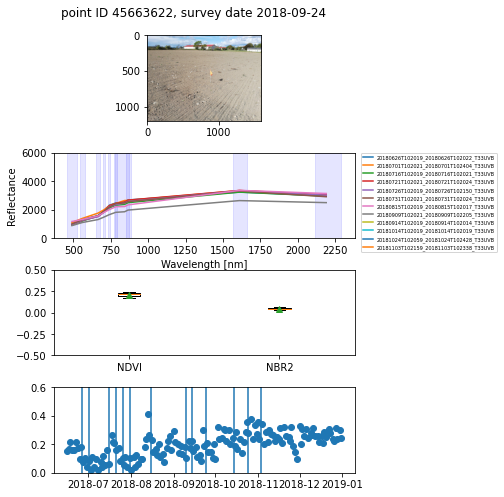

<Figure size 432x288 with 0 Axes>

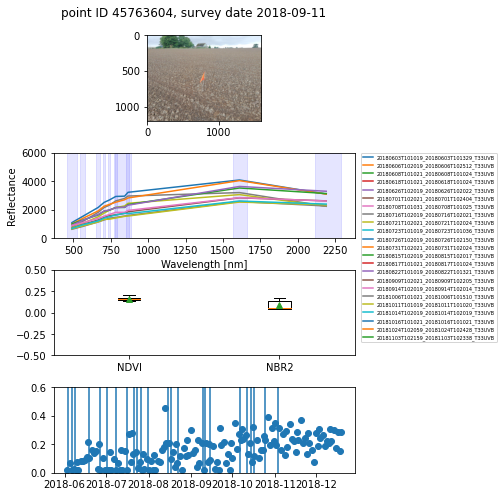

<Figure size 432x288 with 0 Axes>

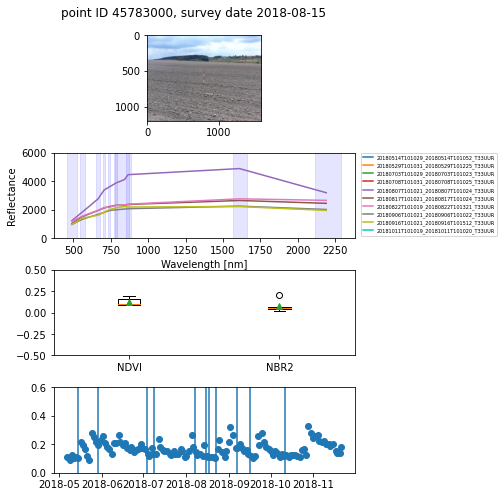

<Figure size 432x288 with 0 Axes>

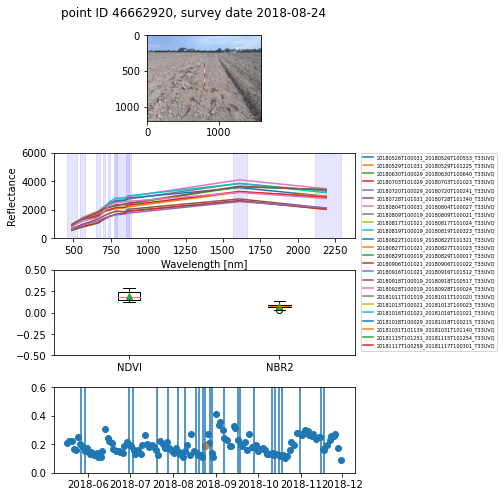

<Figure size 432x288 with 0 Axes>

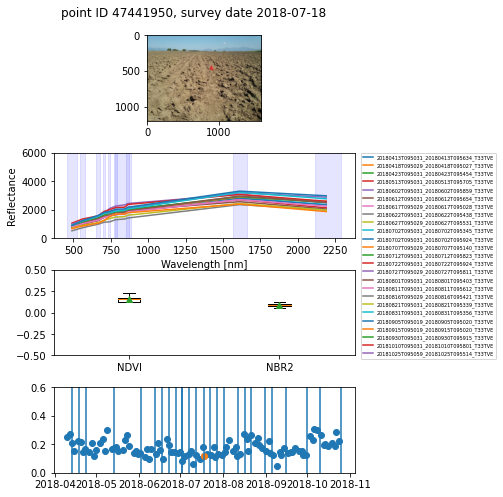

<Figure size 432x288 with 0 Axes>

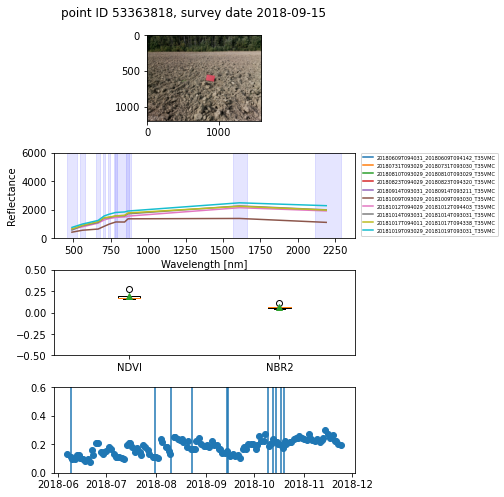

In [61]:

#get lat, lon, pointID, SOC, newdate

#S2collection = ee.ImageCollection("COPERNICUS/S2_SR").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select (['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']).sort("system:time_start")
S2collection = S2joined_cloudfree.filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 30)).select (['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']).sort("system:time_start")

infoo = []
infoodf = []
infoonew = []
infoSMAPP = []

wavelengths = [490,560,665,705,740,783,842,865,1610,2190] 


for ind in data_subsetbare.index:
    
    #Define useful parameters
    #---------------------------------------------------------------------------------------------------------
    pointID = data_subsetbare['POINT_ID'][ind]
    surveydate = data_subsetbare['newdate'][ind]
    SOC = data_subsetbare["SOC"][ind]
    LC = data_subsetbare["H_lc1_labe"][ind]
    soiltype = data_subsetbare["2015A_So_1"][ind]
    CR = data_subsetbare["Crop_resid"][ind]
    CR_LVL = data_subsetbare["Crop_level"][ind]
    R = data_subsetbare["Roughness"][ind]
    moist = data_subsetbare["soil_moist"][ind]
    crust = data_subsetbare["soil_crust"][ind]
    PHOTO=data_subsetbare["H_file_p_4"][ind]
    
    latind = data_subsetbare["H_gps_lat"][ind]
    lonind = data_subsetbare["H_gps_long"][ind]
    
    point = ee.Geometry.Point(lonind, latind)
    
    format = "%Y-%m-%d"
    dt_object = datetime.datetime.strptime(surveydate, format)
    
    delta = datetime.timedelta(days = 100)
    datemin = dt_object - delta
    datemax = dt_object + delta
    
    
    
    
    #apply S2 cloudless
    #----------------------------------------------------------------------------------------------------------
    
    CLOUD_FILTER = 60
    CLD_PRB_THRESH = 30
    NIR_DRK_THRESH = 0.15
    CLD_PRJ_DIST = 1
    BUFFER = 50
    
    S2collection = (ee.ImageCollection("COPERNICUS/S2_SR").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).filterBounds(point).filterDate(datemin, datemax).select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'SCL' ]).sort("system:time_start"))
    S2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY').filterBounds(point).filterDate(datemin, datemax))

    joined = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': S2collection,
        'secondary': S2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))
            
    def add_cloud_bands(img):
        # Get s2cloudless image, subset the probability band.
        cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

        # Condition s2cloudless by the probability threshold value.
        is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

        # Add the cloud probability layer and cloud mask as image bands.
        return img.addBands(ee.Image([cld_prb, is_cloud]))

    #define cloud shadow mask component 
    def add_shadow_bands(img):
        # Identify water pixels from the SCL band.
        not_water = img.select('SCL').neq(6)

        # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
        SR_BAND_SCALE = 1e4
        dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

        # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
        shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')))
    
        # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
        cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
            .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
            .select('distance')
            .mask()
            .rename('cloud_transform'))

        # Identify the intersection of dark pixels with cloud shadow projection.
        shadows = cld_proj.multiply(dark_pixels).rename('shadows')

        # Add dark pixels, cloud projection, and identified shadows as image bands.
        return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

    #function to add cloud and cloud shadow mask
    def add_cld_shdw_mask(img):
        # Add cloud component bands.
        img_cloud = add_cloud_bands(img)

        # Add cloud shadow component bands.
        img_cloud_shadow = add_shadow_bands(img_cloud)

        # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
        is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

        # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
        # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
        is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
            .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
            .rename('cloudmask'))

        # Add the final cloud-shadow mask to the image.
        return img_cloud_shadow.addBands(is_cld_shdw)

    def apply_cld_shdw_mask(img):
        # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
        not_cld_shdw = img.select('cloudmask').Not()

        # Subset reflectance bands and update their masks, return the result.
        return img.select('B.*').updateMask(not_cld_shdw)

    S2joined = joined.map(add_cld_shdw_mask)
    S2joined_cloudfree = S2joined.map(apply_cld_shdw_mask)                  
          
        
        
        
        
    #add NDVI and NBR2 bands
    #---------------------------------------------------------------------------------------------
    
    def addNDVI(image):
        return image.addBands(image.normalizedDifference(['B8', 'B4']).rename('ndvi'))

    
    def addNBR2(image):
        return image.addBands(image.normalizedDifference(['B11', 'B12']).rename('nbr2'))
    #S2collection = S2collection.map(addNDVI)
    S2collection = S2joined_cloudfree.map(addNDVI).map(addNBR2)
    
    
    #threshold the NDVI
    def ndviThres(image):
        #threshold: if NDVI less or equal to 0.3 => 1 else 0
        thres = image.select(['ndvi']).lte(0.3).rename('ndvi_thres')
        return image.addBands(thres)

    S2coll = S2collection.map(ndviThres)
    
    def mask1(image):
        return image.updateMask(image.select('ndvi_thres'))
    
    S2colll= S2coll.map(mask1)
    
    #this is a list of dates S2 images were taken...
    dates = S2colll.aggregate_array("system:time_start").getInfo()
    datess=[]
    for i in dates:
        date = datetime.datetime.fromtimestamp(i//1000.0)
        datess.append(date)
        
    #print(datess)
    
  
    SMAP = ee.ImageCollection('NASA/SMAP/SPL3SMP_E/005').filterBounds(point).filterDate(datemin, datemax).select('soil_moisture_am')
    JAXA_GPM = ee.ImageCollection('JAXA/GPM_L3/GSMaP/v6/operational').filterBounds(point).filterDate(datemin, datemax).select('hourlyPrecipRate')
    
    
    # Get info from the point
    #------------------------------------------------------------------------------------------------------------
    #try S2collection for no applied NDVI mask
    info = S2colll.getRegion(point,20).getInfo() # change collection by series
    
    infoSMAP = SMAP.getRegion(point,900).getInfo()
    infoJAXA = JAXA_GPM.getRegion(point,500).getInfo()
    
    #print(infoSMAP)
    
    SMAPdf = pd.DataFrame(infoSMAP[1:], columns =infoSMAP[0])
    
    #print(infoJAXA)
    df = pd.DataFrame(info[1:], columns =info[0]) 
    
    
    dates = S2colll.aggregate_array("system:time_start").getInfo()
    datess=[]
    for i in dates:
        date = datetime.datetime.fromtimestamp(i//1000.0)
        datess.append(date)
        
    #not intended output
    #df["time"] = pd.to_timedelta(df.time)
    df["time"] =  pd.to_datetime(df['time'], unit='ms').dt.floor('D')
    
    
    df["pointID"] = pointID
    df["surveydate"] = surveydate
    df["SOC"] = SOC
    df["LC"] = LC
    df["soiltype"] = soiltype
    df["CR"] = CR
    df["crust"] = crust
    df["latind"] = latind
    df["lonind"] = lonind
    #df["moisture"] = SMAPdf['soil_moisture_am']
    
    SMAPdf["pointID"] = pointID
    SMAPdf["surveydate"] = surveydate
    SMAPdf['date'] =  pd.to_datetime(SMAPdf['id'], format='%Y%m%d')
    
    """
    pointID = data_subsetbare['POINT_ID'][ind]
    surveydate = data_subsetbare['newdate'][ind]
    SOC = data_subsetbare["SOC"][ind]
    LC = data_subsetbare["H_lc1_labe"][ind]
    soiltype = data_subsetbare["2015A_So_1"][ind]
    CR = data_subsetbare["Crop_resid"][ind]
    CR_LVL = data_subsetbare["Crop_level"][ind]
    R = data_subsetbare["Roughness"][ind]
    moist = data_subsetbare["soil_moist"][ind]
    crust = data_subsetbare["soil_crust"][ind]
    PHOTO=data_subsetbare["H_file_p_4"][ind]
    
    latind = data_subsetbare["H_gps_lat"][ind]
    lonind = data_subsetbare["H_gps_long"][ind]
    dieffe[]
    
    """
    #print(dieffe)
    
    #calculate the thresholds
    #------------------------------------------------------------------------------------------------------------
    #df["NBR2"] = (df["B11"] - df['B12'])/(df["B11"] + df['B12'])
    #df["NDVI"] = (df["B4"] - df['B8'])/(df["B4"] + df['B8'])

    #print(df["ndvi"])
    #print(df["nbr2"])
    
    infoo.append(info)
    infoodf.append(df)
    infoSMAPP.append(SMAPdf)
    
    #rename band names with the S2 central wavelength
    df.rename(columns={'B2':490, 'B3':560,'B4':665,'B5':705, 'B6':740, 'B7':783, 'B8':842, 'B8A':865, 'B11':1610, 'B12':2190}, inplace=True)

    reflectance =df.iloc[:, 4:].T

    #visualisation
    #----------------------------------------------------------------------------------------------------------------------------------------------
    #firsta = S2colll.first()
    #Image(url=firsta.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    
    #def plotfunc (image):
        #Image(url=image.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    #S2colll.map(plotfunc)
    
    #Image(url=i.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    
    #print(type(firsta)) ee.Image... how to plot?? Ask Andrew...
    #Image(url=first.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
        
    """  
    def plotfunc (image):
        Image(url=image.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    
    S2colll.map(plotfunc)
    """
    #LUCAS PICTURE DATABSE PHOTO STUFF
    
    url = PHOTO
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    #plt.imshow(img)
    

    plt.figure() #figsize=(10,30))
    
    
    #fig, (ax1, ax2,ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [24,18,15]}) #also try: height_ratios=[1, 3, 1]
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1,  figsize=(5,7)) 
    
    #try adding inside brackets gridspec_kw={'height_ratios': [4,4]}
    #also try: height_ratios=[1, 3, 1]
    
    fig.suptitle("point ID "+ str(pointID)+ ", survey date "+ str(surveydate))
    fig.tight_layout()

    
    #PLOT EVERYTHING
    ax1.imshow(img)
    
    
    #add a plot that is basically a timeseries of SMAP soil moisture for selected time interval... 
    
    cmap = cm.get_cmap('Spectral') # Colour map (there are many others)

    ax2.plot(df.loc[:, 490: 2190].T, label=df.loc[:,"id"])
    ax2.set_ylim([0, 6000])
    ax2.legend(prop={'size':5}, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    #axes2.set(xlabel="Exam score-1", ylabel="Exam score-2")
    ax2.set(xlabel="Wavelength [nm]", ylabel="Reflectance")
    ax2.axvspan(459.5, 524, color="blue", alpha=0.1)     #B2
    ax2.axvspan(541.5, 575.5, color="blue", alpha=0.1)   #B3
    ax2.axvspan(649, 679, color="blue", alpha=0.1)       #B4
    ax2.axvspan(779.5, 884.5, color="blue", alpha=0.1)   #B8
    ax2.axvspan(697, 711, color="blue", alpha=0.1)       #B5
    ax2.axvspan(733, 747, color="blue", alpha=0.1)       #B6
    ax2.axvspan(772.5, 791.5, color="blue", alpha=0.1)   #B7
    ax2.axvspan(853.5, 874.5, color="blue", alpha=0.1)   #B8a
    ax2.axvspan(1568, 1658, color="blue", alpha=0.1)     #B11
    ax2.axvspan(2115, 2289, color="blue", alpha=0.1)     #B12
    
    
    #Boxplots, too
    #data = df["NBR2"].dropna(), df["NDVI"].dropna()
    data = df["ndvi"].dropna(), df["nbr2"].dropna()
    #axes = plt.axes()
    # Creating plot
    ax3.boxplot(data, showmeans = True)
    ax3.set_ylim([-0.5, 0.5])
    ax3.set_xticklabels(['NDVI', 'NBR2'])
    
    ax4.scatter(SMAPdf["date"], SMAPdf["soil_moisture_am"])
    ax4.axvline(x=dt_object)
    for i in datess:
        ax4.axvline(x=i)
    
    dfdate = SMAPdf[SMAPdf["date"]  == dt_object]
    #if SMAPdf["date"] == df["surveydate"]
    ax4.scatter(dfdate["date"], dfdate["soil_moisture_am"])
    ax4.set_ylim([0, 0.6])
    
    
    #where x is the NBR2 threshold, y is the SMAP soil mositure... 
   
   
    
    
    filename = str(pointID) +'.png'
    #plt.savefig("Figgys/LUCAS2018Points_spectra/" + filename, format='png', dpi=200, bbox_inches="tight")
   
    #dftest = pd.concat([df, SMAPdf], axis=1)
    #dftest['result'] = np.where(dftest['time'] == df['date'], 'match', 'no match')
    #if df["time"] == SMAPdf["date"]:
        #plt.scatter(df["nbr2"], SMAPdf["soil_moisture_am"])
    
        #plt.close()
    """
    if not pd.isnull(df.loc[2, 490]):
        ax2.plot(df.loc[:, 490: 2190].T, label=df.loc[:,"id"])
        ax2.set_ylim([0, 6000])
        ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
        #axes2.set(xlabel="Exam score-1", ylabel="Exam score-2")
        ax2.set(xlabel="Wavelength [nm]", ylabel="Reflectance")
        ax2.axvspan(459.5, 524, color="blue", alpha=0.1)     #B2
        ax2.axvspan(541.5, 575.5, color="blue", alpha=0.1)   #B3
        ax2.axvspan(649, 679, color="blue", alpha=0.1)       #B4
        ax2.axvspan(779.5, 884.5, color="blue", alpha=0.1)   #B8
        ax2.axvspan(697, 711, color="blue", alpha=0.1)       #B5
        ax2.axvspan(733, 747, color="blue", alpha=0.1)       #B6
        ax2.axvspan(772.5, 791.5, color="blue", alpha=0.1)   #B7
        ax2.axvspan(853.5, 874.5, color="blue", alpha=0.1)   #B8a
        ax2.axvspan(1568, 1658, color="blue", alpha=0.1)     #B11
        ax2.axvspan(2115, 2289, color="blue", alpha=0.1)     #B12
   
    
    
    
    #check this out: https://gis.stackexchange.com/questions/342022/trouble-plotting-earth-engine-images-with-folium-using-python
    plt.rc('font', size=20)
    plt.rc('legend', fontsize=15) #fontsize of the legend

    #plt.figure(figsize=(20,10))
    axes = plt.axes()
    
    #plt.plot(df.loc[:, 490: 2190].T, label=df.loc[:,"id"])
    plt.axvspan(459.5, 524, color="blue", alpha=0.1)     #B2
    plt.axvspan(541.5, 575.5, color="blue", alpha=0.1)   #B3
    plt.axvspan(649, 679, color="blue", alpha=0.1)       #B4
    plt.axvspan(779.5, 884.5, color="blue", alpha=0.1)   #B8
    plt.axvspan(697, 711, color="blue", alpha=0.1)       #B5
    plt.axvspan(733, 747, color="blue", alpha=0.1)       #B6
    plt.axvspan(772.5, 791.5, color="blue", alpha=0.1)   #B7
    plt.axvspan(853.5, 874.5, color="blue", alpha=0.1)   #B8a
    plt.axvspan(1568, 1658, color="blue", alpha=0.1)     #B11
    plt.axvspan(2115, 2289, color="blue", alpha=0.1)     #B12
    # Show/save figure as desired.
   
    #ax2.title("point ID "+ str(pointID)+ ", survey date "+ str(surveydate))
    #ax2.xlabel("Wavelength [nm]")
    #ax2.ylabel("Reflectance")
    #axes.set_ylim([0, 6000])
    #ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    plt.show()
    
    df["pointID"] = pointID
    df["surveydate"] = surveydate
    df["SOC"] = SOC
    df["LC"] =  LC
    df["soiltype"] =soiltype
    df["CR"] = CR
    df["CR_LVL"] = CR_LVL
    df["R"] = R
    df["moist"]= moist 
    df["crust"] =crust 
    
    infoonew.append(df)
    #plt.figure()
    #plt.plot(wavelength, refelctance)
    # Show/save figure as desired.
    #plt.show()

#create a "nested" dataframe e.g. in subsetbare, for each row save the reflectance values for each mage within 6-week period
#

"""



[                                        id  longitude   latitude       time  \
0   20180221T111049_20180221T111202_T30TWT  -1.729526  46.976769 2018-02-21   
1   20180226T111011_20180226T111426_T30TWT  -1.729526  46.976769 2018-02-26   
2   20180318T110801_20180318T110755_T30TWT  -1.729526  46.976769 2018-03-18   
3   20180320T105739_20180320T110436_T30TWT  -1.729526  46.976769 2018-03-20   
4   20180417T110651_20180417T110822_T30TWT  -1.729526  46.976769 2018-04-17   
5   20180419T105619_20180419T110127_T30TWT  -1.729526  46.976769 2018-04-19   
6   20180424T105651_20180424T110609_T30TWT  -1.729526  46.976769 2018-04-24   
7   20180504T105621_20180504T110230_T30TWT  -1.729526  46.976769 2018-05-04   
8   20180507T110621_20180507T110835_T30TWT  -1.729526  46.976769 2018-05-07   
9   20180519T105619_20180519T110334_T30TWT  -1.729526  46.976769 2018-05-19   
10  20180524T110041_20180524T110036_T30TWT  -1.729526  46.976769 2018-05-24   
11  20180621T110619_20180621T111349_T30TWT  -1.7295

In [ ]:
data_subsetbarelow = data_subset[data_subset["Crop_resid"]=="y"]
#data_subsetbaremid = data_subset[data_subset["Crop_resid"]=="y"][data_subset["Crop_level"]=="m"]
#data_subsetbarehi = data_subset[data_subset["Crop_resid"]=="y"][data_subset["Crop_level"]=="h"]


infoolow = []
infoodflow = []
infoonew = []

wavelengths = [490,560,665,705,740,783,842,865,1610,2190] 


for ind in data_subsetbarelow.index:
    
    #Define useful parameters
    #---------------------------------------------------------------------------------------------------------
    pointID = data_subsetbarelow['POINT_ID'][ind]
    surveydate = data_subsetbarelow['newdate'][ind]
    SOC = data_subsetbarelow["SOC"][ind]
    LC = data_subsetbarelow["H_lc1_labe"][ind]
    soiltype = data_subsetbarelow["2015A_So_1"][ind]
    CR = data_subsetbarelow["Crop_resid"][ind]
    CR_LVL = data_subsetbarelow["Crop_level"][ind]
    R = data_subsetbarelow["Roughness"][ind]
    moist = data_subsetbarelow["soil_moist"][ind]
    crust = data_subsetbarelow["soil_crust"][ind]
    PHOTO=data_subsetbarelow["H_file_p_4"][ind]
    
    latind = data_subsetbarelow["H_gps_lat"][ind]
    lonind = data_subsetbarelow["H_gps_long"][ind]
    
    point = ee.Geometry.Point(lonind, latind)
    
    format = "%Y-%m-%d"
    dt_object = datetime.datetime.strptime(surveydate, format)
    
    delta = datetime.timedelta(days = 100)
    datemin = dt_object - delta
    datemax = dt_object + delta
    
    
    
    
    #apply S2 cloudless
    #----------------------------------------------------------------------------------------------------------
    
    CLOUD_FILTER = 60
    CLD_PRB_THRESH = 30
    NIR_DRK_THRESH = 0.15
    CLD_PRJ_DIST = 1
    BUFFER = 50
    
    S2collection = (ee.ImageCollection("COPERNICUS/S2_SR").filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20)).filterBounds(point).filterDate(datemin, datemax).select(['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12', 'SCL' ]).sort("system:time_start"))
    S2_cloudless_col = (ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY').filterBounds(point).filterDate(datemin, datemax))

    joined = ee.ImageCollection(ee.Join.saveFirst('s2cloudless').apply(**{
        'primary': S2collection,
        'secondary': S2_cloudless_col,
        'condition': ee.Filter.equals(**{
            'leftField': 'system:index',
            'rightField': 'system:index'
        })
    }))
            
    def add_cloud_bands(img):
        # Get s2cloudless image, subset the probability band.
        cld_prb = ee.Image(img.get('s2cloudless')).select('probability')

        # Condition s2cloudless by the probability threshold value.
        is_cloud = cld_prb.gt(CLD_PRB_THRESH).rename('clouds')

        # Add the cloud probability layer and cloud mask as image bands.
        return img.addBands(ee.Image([cld_prb, is_cloud]))

    #define cloud shadow mask component 
    def add_shadow_bands(img):
        # Identify water pixels from the SCL band.
        not_water = img.select('SCL').neq(6)

        # Identify dark NIR pixels that are not water (potential cloud shadow pixels).
        SR_BAND_SCALE = 1e4
        dark_pixels = img.select('B8').lt(NIR_DRK_THRESH*SR_BAND_SCALE).multiply(not_water).rename('dark_pixels')

        # Determine the direction to project cloud shadow from clouds (assumes UTM projection).
        shadow_azimuth = ee.Number(90).subtract(ee.Number(img.get('MEAN_SOLAR_AZIMUTH_ANGLE')))
    
        # Project shadows from clouds for the distance specified by the CLD_PRJ_DIST input.
        cld_proj = (img.select('clouds').directionalDistanceTransform(shadow_azimuth, CLD_PRJ_DIST*10)
            .reproject(**{'crs': img.select(0).projection(), 'scale': 100})
            .select('distance')
            .mask()
            .rename('cloud_transform'))

        # Identify the intersection of dark pixels with cloud shadow projection.
        shadows = cld_proj.multiply(dark_pixels).rename('shadows')

        # Add dark pixels, cloud projection, and identified shadows as image bands.
        return img.addBands(ee.Image([dark_pixels, cld_proj, shadows]))

    #function to add cloud and cloud shadow mask
    def add_cld_shdw_mask(img):
        # Add cloud component bands.
        img_cloud = add_cloud_bands(img)

        # Add cloud shadow component bands.
        img_cloud_shadow = add_shadow_bands(img_cloud)

        # Combine cloud and shadow mask, set cloud and shadow as value 1, else 0.
        is_cld_shdw = img_cloud_shadow.select('clouds').add(img_cloud_shadow.select('shadows')).gt(0)

        # Remove small cloud-shadow patches and dilate remaining pixels by BUFFER input.
        # 20 m scale is for speed, and assumes clouds don't require 10 m precision.
        is_cld_shdw = (is_cld_shdw.focalMin(2).focalMax(BUFFER*2/20)
            .reproject(**{'crs': img.select([0]).projection(), 'scale': 20})
            .rename('cloudmask'))

        # Add the final cloud-shadow mask to the image.
        return img_cloud_shadow.addBands(is_cld_shdw)

    def apply_cld_shdw_mask(img):
        # Subset the cloudmask band and invert it so clouds/shadow are 0, else 1.
        not_cld_shdw = img.select('cloudmask').Not()

        # Subset reflectance bands and update their masks, return the result.
        return img.select('B.*').updateMask(not_cld_shdw)

    S2joined = joined.map(add_cld_shdw_mask)
    S2joined_cloudfree = S2joined.map(apply_cld_shdw_mask)                  
          
        
        
        
        
    #add NDVI and NBR2 bands
    #---------------------------------------------------------------------------------------------
    
    def addNDVI(image):
        return image.addBands(image.normalizedDifference(['B8', 'B4']).rename('ndvi'))

    
    def addNBR2(image):
        return image.addBands(image.normalizedDifference(['B11', 'B12']).rename('nbr2'))
    #S2collection = S2collection.map(addNDVI)
    S2collection = S2joined_cloudfree.map(addNDVI).map(addNBR2)
    
    
    #threshold the NDVI
    def ndviThres(image):
        #threshold: if NDVI less or equal to 0.3 => 1 else 0
        thres = image.select(['ndvi']).lte(0.3).rename('ndvi_thres')
        return image.addBands(thres)

    S2coll = S2collection.map(ndviThres)
    
    def mask1(image):
        return image.updateMask(image.select('ndvi_thres'))
    
    S2colll= S2coll.map(mask1)
    
    
    # Get info from the point
    #------------------------------------------------------------------------------------------------------------
    #try S2collection for no applied NDVI mask
    info = S2colll.getRegion(point,500).getInfo() # change collection by series
    
    
    df = pd.DataFrame(info[1:], columns =info[0]) 
    
    
    
    df["pointID"] = pointID
    df["surveydate"] = surveydate
    df["SOC"] = SOC
    df["LC"] = LC
    df["soiltype"] = soiltype
    df["CR"] = CR
    df["CR_LVL"] = CR_LVL
    df["crust"] = crust
    df["latind"] = latind
    df["lonind"] = lonind
    
    """
    pointID = data_subsetbare['POINT_ID'][ind]
    surveydate = data_subsetbare['newdate'][ind]
    SOC = data_subsetbare["SOC"][ind]
    LC = data_subsetbare["H_lc1_labe"][ind]
    soiltype = data_subsetbare["2015A_So_1"][ind]
    CR = data_subsetbare["Crop_resid"][ind]
    CR_LVL = data_subsetbare["Crop_level"][ind]
    R = data_subsetbare["Roughness"][ind]
    moist = data_subsetbare["soil_moist"][ind]
    crust = data_subsetbare["soil_crust"][ind]
    PHOTO=data_subsetbare["H_file_p_4"][ind]
    
    latind = data_subsetbare["H_gps_lat"][ind]
    lonind = data_subsetbare["H_gps_long"][ind]
    dieffe[]
    
    """
    #print(dieffe)
    
    #calculate the thresholds
    #------------------------------------------------------------------------------------------------------------
    #df["NBR2"] = (df["B11"] - df['B12'])/(df["B11"] + df['B12'])
    #df["NDVI"] = (df["B4"] - df['B8'])/(df["B4"] + df['B8'])

    #print(df["ndvi"])
    #print(df["nbr2"])
    
    infoolow.append(info)
    infoodflow.append(df)
    
    #rename band names with the S2 central wavelength
    df.rename(columns={'B2':490, 'B3':560,'B4':665,'B5':705, 'B6':740, 'B7':783, 'B8':842, 'B8A':865, 'B11':1610, 'B12':2190}, inplace=True)

    reflectance =df.iloc[:, 4:].T

    #visualisation
    #----------------------------------------------------------------------------------------------------------------------------------------------
    #firsta = S2colll.first()
    #Image(url=firsta.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    
    #def plotfunc (image):
        #Image(url=image.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    #S2colll.map(plotfunc)
    
    #Image(url=i.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    
    #print(type(firsta)) ee.Image... how to plot?? Ask Andrew...
    #Image(url=first.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
        
    """  
    def plotfunc (image):
        Image(url=image.getThumbUrl({'min': 0, 'max': 2000, 'bands':['B4','B3','B2'],'dimensions': 512}))
    
    S2colll.map(plotfunc)
    """
    #LUCAS PICTURE DATABSE PHOTO STUFF
    
    url = PHOTO
    response = requests.get(url)
    img = Image.open(BytesIO(response.content))
    #plt.imshow(img)
    
    
    
    plt.figure() #figsize=(10,30))
    
    
    #fig, (ax1, ax2,ax3) = plt.subplots(3, 1, gridspec_kw={'height_ratios': [24,18,15]}) #also try: height_ratios=[1, 3, 1]
    fig, (ax1, ax2) = plt.subplots(2, 1,  figsize=(5,7)) 
    
    #try adding inside brackets gridspec_kw={'height_ratios': [4,4]}
    #also try: height_ratios=[1, 3, 1]
    
    fig.suptitle("point ID "+ str(pointID)+ ", survey date "+ str(surveydate))
    fig.tight_layout()

    
    #PLOT EVERYTHING
    #ax1.imshow(img)
    
    
    ax1.plot(df.loc[:, 490: 2190].T, label=df.loc[:,"id"])
    ax1.set_ylim([0, 6000])
    ax1.legend(prop={'size':5}, bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
    
    #axes2.set(xlabel="Exam score-1", ylabel="Exam score-2")
    ax1.set(xlabel="Wavelength [nm]", ylabel="Reflectance")
    ax1.axvspan(459.5, 524, color="blue", alpha=0.1)     #B2
    ax1.axvspan(541.5, 575.5, color="blue", alpha=0.1)   #B3
    ax1.axvspan(649, 679, color="blue", alpha=0.1)       #B4
    ax1.axvspan(779.5, 884.5, color="blue", alpha=0.1)   #B8
    ax1.axvspan(697, 711, color="blue", alpha=0.1)       #B5
    ax1.axvspan(733, 747, color="blue", alpha=0.1)       #B6
    ax1.axvspan(772.5, 791.5, color="blue", alpha=0.1)   #B7
    ax1.axvspan(853.5, 874.5, color="blue", alpha=0.1)   #B8a
    ax1.axvspan(1568, 1658, color="blue", alpha=0.1)     #B11
    ax1.axvspan(2115, 2289, color="blue", alpha=0.1)     #B12
    
    
    #Boxplots, too
    #data = df["NBR2"].dropna(), df["NDVI"].dropna()
    data = df["ndvi"].dropna(), df["nbr2"].dropna()
    #axes = plt.axes()
    # Creating plot
    ax2.boxplot(data, showmeans = True)
    ax2.set_ylim([-0.5, 0.5])
    ax2.set_xticklabels(['NDVI', 'NBR2'])
    
    
    filename = str(pointID) +'.png'
    #plt.savefig("Figgys/LUCAS2018Points_spectra_residue/" + filename, format='png', dpi=200, bbox_inches="tight")
   
    plt.close()

In [189]:
#add moisture info.
#SMAP-Sentinel-1? or 



for i in infoodflow:
    print (i["pointID"][0], i["CR_LVL"][0],  "NDVI", i["ndvi"].mean(), " NBR2", i["nbr2"].mean(), i["LC"][0])

33362924 l NDVI nan  NBR2 nan Other bare soil
34382818 h NDVI nan  NBR2 nan Rape and turnip rape
34702878 m NDVI nan  NBR2 nan Common wheat
34922974 m NDVI nan  NBR2 nan Common wheat
34982356 m NDVI nan  NBR2 nan Maize
36802602 l NDVI 0.2737509545738551  NBR2 0.13428668060987273 Other bare soil
36883144 h NDVI 0.04193952530170814  NBR2 0.024494448957208537 Other bare soil
37742584 h NDVI 0.27875681460713414  NBR2 0.13192380055980932 Other bare soil
37962708 m NDVI 0.252139931327369  NBR2 0.07707657851453684 Common wheat
38302756 h NDVI nan  NBR2 nan Other bare soil
38782764 h NDVI 0.2854601381923743  NBR2 0.15290524007989764 Other bare soil
39442712 l NDVI nan  NBR2 nan Barley
39582726 h NDVI 0.2967948717948718  NBR2 0.0913907284768212 Rape and turnip rape
39622726 m NDVI 0.29354202354853126  NBR2 0.09113695609922394 Other bare soil
40062742 h NDVI 0.26076575334737967  NBR2 0.13359348759046574 Rape and turnip rape
41741970 h NDVI 0.2656647854851212  NBR2 0.1598600440082462 Barley
42363

In [ ]:
# precipitation hourly rate


In [193]:
dataset = ee.ImageCollection('JAXA/GPM_L3/GSMaP/v6/operational').filter(ee.Filter.date('2018-06-06', '2018-06-07'));
precipitation = dataset.select('hourlyPrecipRate')

#print(precipitation)

In [ ]:
import folium

locations = data_subset[["H_gps_lat", "H_gps_long"]]
locationlist = locations.values.tolist()
print(len(locationlist))

my_map = folium.Map(location=[50,10], zoom_start=4)

for point in range(0, len(locationlist)):
    folium.Marker(locationlist[point], popup=data_subset['POINT_ID'][point]).add_to(my_map)

#my_map = folium.Map(location=[20,30], zoom_start=10)
my_map


In [43]:
# Create a geometry list from the GeoDataFrame
geometry = geopandas.points_from_xy(data_subset.H_gps_long, data_subset.H_gps_lat)

print(geometry)

#create a geodataframe
geo_df = geopandas.GeoDataFrame(
    data_subset, geometry=geometry
)
print(geo_df)



"""
# Iterate through list and add a marker for each volcano, color-coded by its type.

i = 0
for coordinates in geo_df_list:
    # assign a color marker for the type of volcano, Strato being the most common
    if data_susbet.2015A_So_1[i] == "LV":
        type_color = "pink"
    elif data_susbet.2015A_So_1[i][i] == "CM":
        type_color = "blue"
    elif data_susbet.2015A_So_1[i][i] == "Shield volcano":
        type_color = "orange"
    elif geo_df.Type[i] == "Lava dome":
        type_color = "pink"
    else:
        type_color = "purple"

    # Place the markers with the popup labels and data
    map.add_child(
        folium.Marker(
            location=coordinates,
            popup=
                "Year: " + str(geo_df.Year[i]) + "<br>"
                + "Name: " + str(geo_df.Name[i]) + "<br>"
                + "Country: " + str(geo_df.Country[i]) + "<br>"
                + "Type: " + str(geo_df.Type[i]) + "<br>"
                + "Coordinates: " + str(geo_df_list[i]),
            icon=folium.Icon(color="%s" % type_color),
        )
    )
    i = i + 1

#Set the zoom to the maximum possible
my_map.fit_bounds(my_map.get_bounds())

"""

<GeometryArray>
Length: 7, dtype: geometry
   field_1  POINT_ID H_survey_d       H_lc1_labe Remark Crop_resid Crop_level  \
1        1  27401840   26/08/18  Other bare soil      y          y          h   
2        3  28181874   08/07/18  Other bare soil      y          y          l   
3        5  28761726   26/06/18  Other bare soil      y          y          h   
4        6  28761906   08/08/18  Other bare soil      y          y          l   
5        8  28921678   08/07/18  Other bare soil      y          y          l   
6        9  29161714   19/06/18  Other bare soil      y          n        NaN   
7       11  29261832   01/07/18  Other bare soil      y          n        NaN   

  Roughness      ID  H_point_id  ... 2015A_BI_4 2015A_BI_5 2015A_BI_6  \
1         n   72867    27401840  ...       98.0        2.0      64.90   
2         n  218396    28181874  ...       87.0        4.0      57.27   
3         n  437658    28761726  ...       91.0        2.0      67.19   
4         n   84

'\n# Iterate through list and add a marker for each volcano, color-coded by its type.\n\ni = 0\nfor coordinates in geo_df_list:\n    # assign a color marker for the type of volcano, Strato being the most common\n    if data_susbet.2015A_So_1[i] == "LV":\n        type_color = "pink"\n    elif data_susbet.2015A_So_1[i][i] == "CM":\n        type_color = "blue"\n    elif data_susbet.2015A_So_1[i][i] == "Shield volcano":\n        type_color = "orange"\n    elif geo_df.Type[i] == "Lava dome":\n        type_color = "pink"\n    else:\n        type_color = "purple"\n\n    # Place the markers with the popup labels and data\n    map.add_child(\n        folium.Marker(\n            location=coordinates,\n            popup=\n                "Year: " + str(geo_df.Year[i]) + "<br>"\n                + "Name: " + str(geo_df.Name[i]) + "<br>"\n                + "Country: " + str(geo_df.Country[i]) + "<br>"\n                + "Type: " + str(geo_df.Type[i]) + "<br>"\n                + "Coordinates: " + str

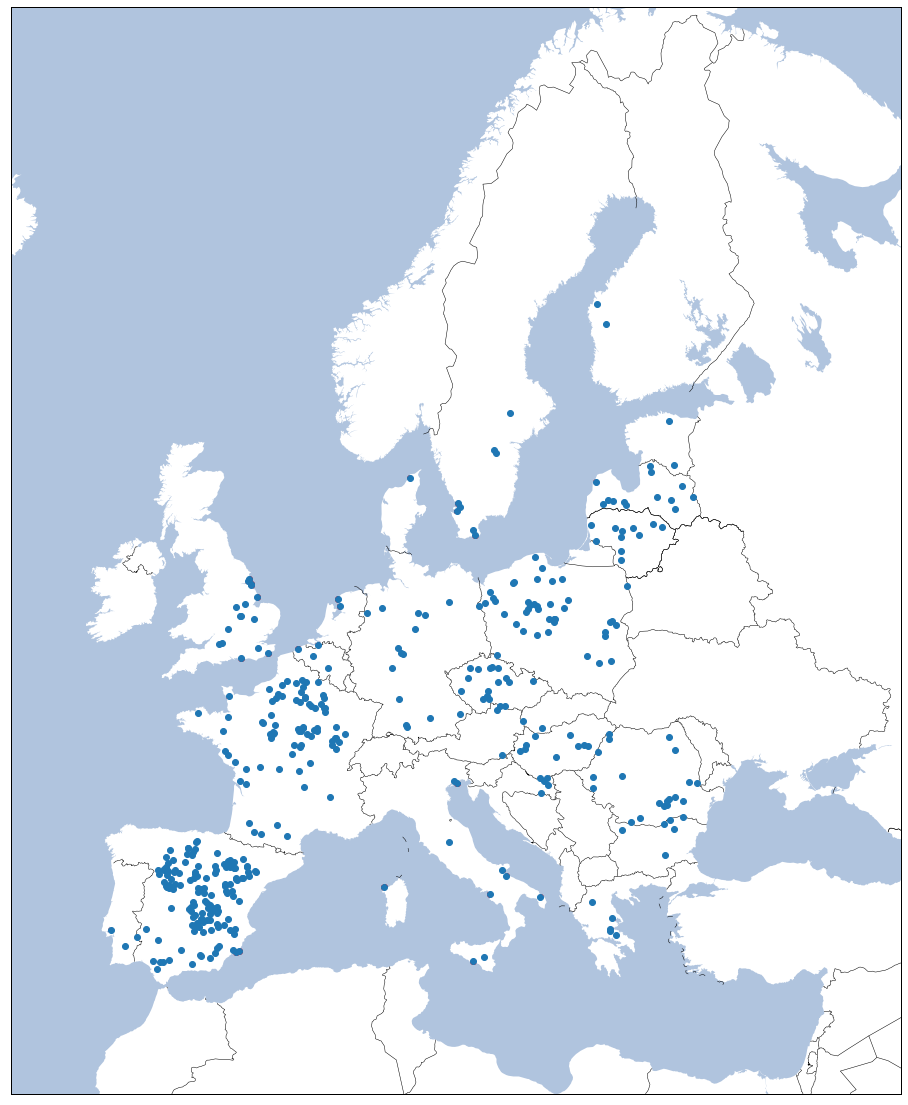

In [119]:


plt.figure(figsize=(40,20))
m = Basemap(resolution='i', # c, l, i, h, f or None. crude, low, intermediate, high or full.
        projection='merc',
        lat_0=37.80, lon_0=-96.02,
        llcrnrlon=-15.22,
        urcrnrlon=40.83,
        llcrnrlat= 30.25,
        urcrnrlat= 70.26,
        area_thresh=10000)


#check projection ?? 
#m.drawcoastlines()
m.drawcountries()
#m.drawstates()
m.scatter(x, y, marker='o', color='r')
m.drawmapboundary(fill_color='lightsteelblue')
m.fillcontinents(color='white',lake_color='lightsteelblue')

#but the actual map coordinates are
x,y = m(lon, lat)
m.plot(x, y, 'o', markersize=6)

plt.show()

In [2]:
# Configure the pretty printing output & initialize earthengine.
pp = pprint.PrettyPrinter(depth=4)

# Load a Landsat 8 ImageCollection for a single path-row.
collection = (ee.ImageCollection('LANDSAT/LC08/C01/T1_TOA')
    .filter(ee.Filter.eq('WRS_PATH', 44))
    .filter(ee.Filter.eq('WRS_ROW', 34))
    .filterDate('2014-03-01', '2014-08-01'))
#pp.pprint('Collection: '+str(collection.getInfo())+'\n')

# Get the number of images.
count = collection.size()
print('Number of images in collection: ', str(count.getInfo())+'\n')

# Get the date range of images in the collection.
range = collection.reduceColumns(ee.Reducer.minMax(), ["system:time_start"])
print('Date range: ', str(ee.Date(range.get('min')).getInfo()), str(ee.Date(range.get('max')).getInfo())+'\n')

# Get statistics for a property of the images in the collection.
sunStats = collection.aggregate_stats('SUN_ELEVATION')
pp.pprint('Sun elevation statistics: '+str(sunStats.getInfo())+'\n')

# Sort by a cloud cover property, get the least cloudy image.
image = ee.Image(collection.sort('CLOUD_COVER').first())
print('Least cloudy image: ', str(image.getInfo())+'\n')

# Limit the collection to the 5 most recent images.
recent = collection.sort('system:time_start', False).limit(5)
#pp.pprint('Recent images: '+str(recent.getInfo())+'\n')

# Get size of collection in bytes
print('Total size of Collection with 5 most recent images : '+str((recent.reduceColumns(ee.Reducer.sum(), ['system:asset_size']).getInfo()['sum'])))

EEException: Earth Engine client library not initialized. Run `ee.Initialize()`

In [ ]:
# Load Landsat 5 data, filter by date and bounds.
collection = ee.ImageCollection('LANDSAT/LT05/C01/T2').filterDate('1987-01-01', '1990-05-01').filterBounds(ee.Geometry.Point(25.8544, -18.08874))

# Also filter the collection by the IMAGE_QUALITY property.
filtered = collection.filterMetadata('IMAGE_QUALITY', 'equals', 9)

# Create two composites to check the effect of filtering by IMAGE_QUALITY.
badComposite = ee.Algorithms.Landsat.simpleComposite(collection, 75, 3) # percentile and cloud score
goodComposite = ee.Algorithms.Landsat.simpleComposite(filtered, 75, 3)    

In [ ]:
import folium
!pip install geehydro # Life saver for plotting GEE stuff with Python!
import geehydro

# Use folium to visualize the imagery.
map = folium.Map(location=[-18.08874,25.8544],zoom_start=9)

map.addLayer(goodComposite, {'bands': ['B3', 'B2', 'B1'], 'gain':3.5}, 'good composite')
map.addLayer(badComposite, {'bands': ['B3', 'B2', 'B1'], 'gain':3.5}, 'bad composite')
folium.LayerControl().add_to(map)
map

In [ ]:
# Load MODIS EVI (Enhanced Vegetation index) imagery.
collection = ee.ImageCollection('MODIS/006/MYD13A1').select('EVI')

# Define reference conditions from the first 10 years of data
# Sort chronologically in descending order
reference = collection.filterDate('2001-01-01', '2010-12-31').sort('system:time_start', False)

# Compute the mean of the first 10 years.
mean = reference.mean()

# Compute anomalies by subtracting the 2001-2010 mean from each image in a
# collection of 2011-2014 images. Copy the date metadata over to the
# computed anomaly images in the new collection.

def subtracting(image):
  return image.subtract(mean).set('system:time_start', image.get('system:time_start'))

filtered = collection.filterDate('2011-01-01', '2014-12-31')

series = collection.map(subtracting)
series_sum = series.sum()

# Display cumulative anomalies.
# Use folium to visualize the imagery.
map3 = folium.Map(location=[40.2,-100.811],zoom_start=5)
map3.addLayer(series_sum, {'min': -60000, 'max': 60000, 'palette': ['FF0000', '000000', '00FF00']}, 'EVI anomaly')
map3  

In [ ]:
%matplotlib inline
from IPython.display import Image
import ee, datetime
import pandas as pd
from pylab import *
from matplotlib.pylab import rcParams


# Define point in the Amazon rainforest
point = ee.Geometry.Point(-65.544, -4.894)

# Get info from the point

info = collection.getRegion(point,500).getInfo() # change colelction by series
print(info)

# Reshape image collection 
# Spearate header from data, and store data in an array
header = info[0]
data = array(info[1:])

# Extract time from data
iTime = header.index('time')
time = [datetime.datetime.fromtimestamp(i/1000) for i in (data[0:,iTime].astype(int))]

# List of used image bands
band_list = ['EVI']

iBands = [header.index(b) for b in band_list]
yData = data[0:,iBands].astype(np.float)
#print(yData)

evi = yData[:,0]*0.0001 # USGS specifications: scale factor
#print(evi)

# Reshape EVI array into Pandas Dataframe
df = pd.DataFrame(data=evi, columns=['EVI'])
#print(df)

df['Date'] = pd.Series(time, index=df.index)
#print(df)

In [ ]:
# Plotting

rcParams['figure.figsize'] = 15, 6
df.plot(y='EVI',x='Date')
plt.show()
